***

##  Index

1. [Business Understanding](#1.-Business-Understanding) <p>

2. [Data Understanding](#2.-Data-Understanding)

    2.1. [Load and Collecting Data](#2.1-Load-and-Collecting-Data)
    
    2.2. [Describe Data](#2.2-Describe-Data)
    
    2.3. [Explore Data](#2.3-Explore-Data)
    
    2.4. [Data Quality](#2.4-Data-Quality)
    
    2.5. [Data Relationships](#2.5-Data-Relationships) <p>
    
3. [Data Preparation](#3.-Data-Preparation)

    3.1. [Data Cleaning](#3.1-Data-Cleaning)
    
    3.2. [Data Engineering](#3.2-Data-Engineering)<p>
    
4. [Modelling](#4.-Modelling)
          
    4.1. [Logistic Regression](#4.1-Logistic-Regression)
          
    4.2. [Evaluation](#4.1-Evaluation)<p>

5. [Deployment](#5.-Deployment)<p>

***

## Necessary installs

## Imports

In [293]:
#Data Manipulation and Analysis
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Data Preprocessing and Encoding
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

#Statistical Analysis
import scipy.stats as stats
from scipy.stats import chi2, chi2_contingency
from scipy.stats import pearsonr, spearmanr

#Feature Selection
from sklearn.feature_selection import RFE, SelectKBest

#Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, auc, classification_report

#Supervised Learning Models
from sklearn.linear_model import Lasso, SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#Cross-Validation and Model Evaluation
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold, ShuffleSplit, StratifiedShuffleSplit

#Miscellaneous
import re
from sklearn import metrics
from IPython.display import display, HTML
import xgboost as xgb
from sklearn.inspection import permutation_importance

In [305]:
#precautions
%autosave 90

# Setting global variables
pd.set_option('display.max_columns', 30)

#colors
my_cmap = sns.diverging_palette(306, 306, as_cmap=True)

def get_custom_color_palette_hash():
    return LinearSegmentedColormap.from_list("", [
        '#ffffff', '#e5c8e3', '#cc91c7',
        '#AB49A2',
        '#9c6871', '#7a3642', '#5a0413'
    ])

cmap = get_custom_color_palette_hash()

color_dict = {0: '#AB49A2', 1: '#5a0413'}

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

Autosaving every 90 seconds


## Function

In [3]:
def Describe(df):

    '''
    Describes data about the Dataset
    '''
    unique_vals = pd.DataFrame(
        [(col, df[col].nunique()) for col in df.columns], 
        columns =['Feature', 'N_unique_vals']
    )

    unique_vals.set_index('Feature', inplace = True)
    unique_vals = pd.concat([unique_vals, pd.DataFrame(df.dtypes).rename(columns = {0:'d_type'})], axis = 1)
    unique_vals['N_nulls'] = df.isna().sum().values

    obj_cols = unique_vals[unique_vals['d_type'] == 'object'].index

    for col in obj_cols:
        unique_vals.loc[col, 'N_nulls'] += len(df[(df[col] == '') | (df[col] == ' ')])
    
    print(f'Data size: {df.shape[0]} x {df.shape[1]}')
    return unique_vals[['N_unique_vals', 'N_nulls', 'd_type']]

In [4]:
def missing_value_reporter(data, threshold=None):
    
    '''
    Returns pandas dataframe with feature's missing values count in absolute 
    and relative frequency
    after a threshold is parsed (max % of column missing values), so it'll 
    tell if the features are 
    above or bellow the desired missing threshold limit (True for above or 
    False for bellow).
    
    If the threshold is not provided, it defaults to None.
     Args:
        data - input for data
        threshold - input for threshold variable from 0 to 1
        
    '''
    na_count = data.isna().sum() 
    na_count = na_count[na_count > 0]
    na_abs_frq = na_count.values
    na_rel_frq = round(na_count/len(data),2)
    missings = pd.DataFrame({'Feature': na_count.index, 'Nº of missings': 
    na_abs_frq, '% of missings': na_rel_frq})
    missings = missings.sort_values(by = 'Nº of missings', ascending = False)
    
    if threshold:
        missings['Above threshold'] = [True if x > threshold else False for x 
        in missings['% of missings']]
        
    return missings

In [5]:
def numerical_summary_stats(data):

    # Select only numerical columns
    num_cols = data.select_dtypes(include=['number']).columns.tolist()

    # Calculate summary statistics for numerical columns
    summary_stats = data[num_cols].describe().T.reset_index()

    # Rename columns for readability
    summary_stats.rename(columns={'index': 'column', 'count': 'non_missing', 
                                  '50%': 'median', 'std': 'stdev'}, 
                                  inplace=True)

    # Calculate coefficient of variation (CV)
    summary_stats['CV'] = summary_stats['stdev'] / summary_stats['mean']

    return summary_stats

In [6]:
def categorical_summary_stats(data):

    # Select only categorical columns
    cat_cols = data.select_dtypes(include=['object',  
    'category']).columns.tolist()

    # Calculate frequency counts for each categorical column
    freq_counts = pd.concat([data[col].value_counts().reset_index() for col 
    in cat_cols])

    # Rename columns for readability
    freq_counts.rename(columns={'index': 'category', cat_cols[0]: 'count'}, 
    inplace=True)

    # Add a column for the proportion of each category
    freq_counts['proportion'] = freq_counts['count'] / freq_counts['count'].sum()

    return freq_counts

In [97]:
def plot_distributions(df):
    plt.style.use('ggplot')
    sns.set_style('white')
    for col in df.columns:
        sns.displot(df[col],
                    kde=True,
                    height=4,
                    aspect=3,
                    color='#AB49A2',
                    edgecolor='#5a0413',
                    alpha=0.9
                   )
        plt.grid(True, linestyle='--', alpha=0.5, color='gray')
        plt.title(f"Distribution of {col}")
        plt.show()

In [364]:
def plot_correlations_num(df):
    plt.style.use('ggplot')
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap=my_cmap, annot=True, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 8})
    plt.title("Correlation Matrix")
    plt.show()

In [365]:
def plot_correlations_cat_bin(df, target_variable):
    '''This code computes a correlation matrix between categorical features (between them) and a binary variable (the target)
    '''
    plt.style.use('ggplot')
    # Compute Cramer's V for each pair of categorical variables
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    cramer_v_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
    
    for var1 in categorical_vars:
        for var2 in categorical_vars:
            confusion_matrix = pd.crosstab(df[var1], df[var2])
            chi2, p, _, _ = stats.chi2_contingency(confusion_matrix)
            n = confusion_matrix.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * min(confusion_matrix.shape) - 1))
            cramer_v_matrix.loc[var1, var2] = cramer_v
    
    # Compute Cramer's V between each categorical variable and the target variable
    cramer_v_target = pd.DataFrame(index=categorical_vars, columns=[target_variable])
    
    for var in categorical_vars:
        confusion_matrix = pd.crosstab(df[var], df[target_variable])
        chi2, p, _, _ = stats.chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        cramer_v = np.sqrt(chi2 / (n * min(confusion_matrix.shape) - 1))
        cramer_v_target.loc[var, target_variable] = cramer_v
    
    # Combine the Cramer's V matrices
    cramer_v_matrix = pd.concat([cramer_v_matrix, cramer_v_target], axis=1)
    
    # Convert Cramer's V values to float
    cramer_v_matrix = cramer_v_matrix.astype(float)
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cramer_v_matrix, cmap=cmap, annot=True, vmin=0, vmax=1, linewidths=0.5, annot_kws={"fontsize": 8})
    plt.title("Cramer's V - Correlation Matrix")
    plt.show()

In [379]:
def plot_correlations_bin_bin(df):
    '''Plot correlations between binary variables
    '''
    plt.style.use('ggplot')
    binary_variables = df[['IsCanceled','IsRepeatedGuest']]

    phi_matrix = pd.DataFrame(index=binary_variables.columns, columns=binary_variables.columns)

    for var1 in binary_variables.columns:
        for var2 in binary_variables.columns:
            if var1 != var2:
                contingency_table = pd.crosstab(df[var1], df[var2])
                n = contingency_table.values.sum()
                phi_coefficient = np.sqrt((contingency_table / n).values).sum()
                phi_matrix.loc[var1, var2] = phi_coefficient

    plt.figure(figsize=(10, 8))
    sns.heatmap(phi_matrix.astype(float), cmap=my_cmap, annot=True, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 12})
    plt.title("Phi Coefficient - Correlation Matrix")
    plt.show()

In [99]:
def plot_boxplots(df):
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    plt.style.use('ggplot')
    sns.set_style('white')
    for col in num_cols:
        if df[col].nunique() > 2:  # check if not binary
            fig, ax = plt.subplots(figsize=(20, 3))
            sns.boxplot(x=df[col], color='#AB49A2', width=0.5, fliersize=3)
            plt.grid(True, linestyle='--', alpha=0.5, color='gray')
            ax.set_title(f"Boxplot of {col}")
            plt.show()

In [100]:
def num_y_relationship(df, y_col):
    # define color dictionary
    color_dict = {0: '#AB49A2', 1: '#5a0413'}

    # Select numerical columns that are not binomial
    num_cols = []
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if df[col].nunique() > 2:
            num_cols.append(col)

    # Plot distributions
    plt.style.use('ggplot')
    sns.set_style('white')
    for col in num_cols:
        sns.displot(df,
                    x=col,
                    hue=y_col,
                    palette=color_dict,
                    height=3,
                    aspect=4,
                    edgecolor='black',
                    multiple='dodge',
                    alpha=1
                   )
        plt.grid(True, linestyle='--', alpha=0.5, color='gray')
        plt.title(f"Distribution of {col}")
        plt.show()

In [11]:
def cat_y_relationship(df, y_col):
    # Define color dictionary
    color_dict = {0: '#AB49A2', 1: '#5a0413'}

    # Select categorical columns with less than 11 unique values
    cat_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique() <= 10:
            cat_cols.append(col)

    # Plot distributions
    plt.style.use('ggplot')
    for col in cat_cols:
        sns.countplot(data=df,
                      x=col,
                      hue=y_col,
                      palette=color_dict,
                      edgecolor='black')

        plt.title(f"Distribution of {col}")
        plt.show()

In [101]:
def cat_y_relationship(df, y_col):
    # Define color dictionary
    color_dict = {0: '#AB49A2', 1: '#5a0413'}

    # Select categorical columns with less than 11 unique values
    cat_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique() <= 10:
            cat_cols.append(col)

    # Plot distributions
    plt.style.use('ggplot')
    sns.set_style('white')
    for col in cat_cols:
        sns.countplot(data=df,
                      x=col,
                      hue=y_col,
                      palette=color_dict,
                      edgecolor='black',
                      alpha=1
                     )
                        
        plt.grid(True, linestyle='--', alpha=0.5, color='gray')
        plt.title(f"Distribution of {col}")
        plt.show()

In [13]:
def percentage_remaining_data_IQR(data, criterion):
    '''
    Computes the percentage of remaining data after removing outliers using IQR method with specified criterion.
    
    Args:
        data (pandas.core.frame.DataFrame): input data
        criterion (float): criterion for outlier removal (IQR multiplier)
        
    Returns:
        None: prints percentage of remaining data after outlier removal using IQR method with specified criterion
    '''
    Q1 = data.quantile(.25) # value of first quartile
    Q3 = data.quantile(.75) # value of third quartile
    IQR = Q3 - Q1 # interquartile range
    lower_lim = Q1 - criterion * IQR # setting min limit
    upper_lim = Q3 + criterion * IQR # setting max limit

    filters = []
    for col in data.select_dtypes(include=np.number).columns:
        llim = lower_lim[col]
        ulim = upper_lim[col]
        filters.append(data[col].between(llim, ulim, inclusive='both'))

    data_no_outliers = data[np.all(filters, axis=0)]
    percentage_remaining = round(data_no_outliers.shape[0] / data.shape[0] * 100)

    print(percentage_remaining, '%', 'data kept using IQR')

    
def percentage_remaining_data_Zscore(data, criterion):
    '''
    Computes the percentage of remaining data after removing outliers using Z-score method with specified criterion.
    
    Args:
        data (pandas.core.frame.DataFrame): input data
        criterion (float): criterion for outlier removal (number of standard deviations from the mean)
        
    Returns:
        None: prints percentage of remaining data after outlier removal using Z-score method with specified criterion
    '''
    mean = data.mean() # mean of each column
    std = data.std() # standard deviation of each column
    lower_lim = mean - criterion * std # setting min limit
    upper_lim = mean + criterion * std # setting max limit

    filters = []
    for col in data.select_dtypes(include=np.number).columns:
        llim = lower_lim[col]
        ulim = upper_lim[col]
        filters.append(data[col].between(llim, ulim, inclusive='both'))

    data_no_outliers = data[np.all(filters, axis=0)]
    percentage_remaining = round(data_no_outliers.shape[0] / data.shape[0] * 100)

    print(percentage_remaining, '%', 'data kept using Z-score')

In [14]:
def info(df):
    '''
    Returns main information about the Dataset
    '''
    unique_vals = pd.DataFrame(
        [(col, df[col].nunique()) for col in df.columns], 
        columns =['Feature', 'N_unique_vals']
    )

    unique_vals.set_index('Feature', inplace = True)
    unique_vals = pd.concat([unique_vals, pd.DataFrame(df.dtypes).rename(columns = {0:'d_type'})], axis = 1)
    unique_vals['N_nulls'] = df.isna().sum().values

    obj_cols = unique_vals[unique_vals['d_type'] == 'object'].index

    for col in obj_cols:
        unique_vals.loc[col, 'N_nulls'] += len(df[(df[col] == '') | (df[col] == ' ')])
    
    print(f'Data size: {df.shape[0]} x {df.shape[1]}')
    return unique_vals[['N_unique_vals', 'N_nulls', 'd_type']]

In [15]:
def min_max_scale(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [16]:
def select_features_rfe(X_train, y_train, n_features_to_select, step):
    # create a random forest classifier object
    rf = RandomForestClassifier()

    # create an RFE object to select the top n_features_to_select features
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=step)

    # fit the RFE object to the training data
    rfe.fit(X_train, y_train)

    # return the selected features
    return X_train.columns[rfe.support_]

In [17]:
def select_features_lasso(X_train, y_train):
    """
    Select features using Lasso regularization.

    Parameters:
    X_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data target variable.

    Returns:
    selected_features (list): List of selected feature names.
    """

    # create a Lasso object
    lasso = Lasso(alpha=0.1)

    # fit the Lasso object to the training data
    lasso.fit(X_train, y_train)

    # get the coefficients of the Lasso object and select the features with non-zero coefficients
    coef = lasso.coef_
    selected_features = X_train.columns[coef != 0].tolist()

    return selected_features

In [18]:
def select_features_spearman(X_train, y_train, n_features_to_select):
    # create an empty list to store the correlation coefficients
    correlations = []

    # loop through each feature and calculate its correlation with the target variable
    for feature in X_train.columns:
        correlation, _ = spearmanr(X_train[feature], y_train)
        correlations.append(correlation)

    # create a dataframe with the feature names and their correlation coefficients
    correlation_df = pd.DataFrame({'feature': X_train.columns, 'correlation': correlations})

    # sort the dataframe by correlation coefficient and select the top n_features_to_select features
    selected_features = correlation_df.sort_values(by='correlation', ascending=False).head(n_features_to_select)['feature'].values

    # return the selected features
    return selected_features

In [19]:
def select_features_phi(X_train, y_train, n_features_to_select):
    
    # create an empty list to store the correlation coefficients
    correlations = []

    # loop through each binary feature and calculate its phi coefficient with the target variable
    for feature in X_train.columns:
        contingency_table = pd.crosstab(X_train[feature], y_train)
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        phi_coefficient = np.sqrt(chi2/X_train.shape[0])
        correlations.append(phi_coefficient)

    # create a dataframe with the feature names and their correlation coefficients
    correlation_df = pd.DataFrame({'feature': X_train.columns, 'correlation': correlations})

    # sort the dataframe by correlation coefficient and select the top n features
    selected_features = correlation_df.sort_values(by='correlation', ascending=False).head(n_features_to_select)['feature'].values

    # print the selected features
    print(selected_features)
    
    return selected_features

In [20]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

## <font color='SeaGreen'>1. Business Understanding</font> 

<font color='SeaGreen'> __Understand the problem to be solved, define the objectives and the success criteria, and develop a plan to achieve those objectives.__

<p>&nbsp;&nbsp;&nbsp;&nbsp;The business problem is the negative impact of cancellations on the hotel industry, which results in missed revenue opportunities, unsold inventory, and additional costs associated with overbooking. The C hotel chain has experienced high cancellation rates, which have forced them to implement restrictive cancellation policies and aggressive overbooking policies. However, both strategies have drawbacks that have negatively impacted the business. The hotel chain wants to develop predictive models to forecast net demand and minimize the negative impact of cancellations while maximizing revenue. The goal is to reduce cancellation rates to 20% and find a solution that balances revenue and risk. The business problem is to develop a successful machine learning model that achieves this goal and meets the hotel chain's requirements and business objectives.

## <font color='SeaGreen'>2. Data Understanding</font>

<font color='SeaGreen'> __Collect and explore the data to be used in the project, identify data quality issues, and determine which data is relevant to the analysis.__

### 2.1 Load and Collecting Data

In [347]:
url2 = 'https://raw.githubusercontent.com/toomingos/Hotel-Case-Study/main/UNSD%20%E2%80%94%20Methodology.csv'
Regions = pd.read_csv(url2, delimiter=';')
Regions = Regions[['ISO-alpha3 Code','Sub-region Name']]

In [348]:
url1 = 'https://github.com/TMVicente20221355/files-desorganizados/blob/main/Case4_H2.csv'
H2 = pd.read_csv(url1, delimiter=',',error_bad_lines = False)
H2["ReservationStatusDate"] = pd.to_datetime(H2["ReservationStatusDate"])
H2['ArrivalDateMonth'] = pd.to_datetime(H2['ArrivalDateMonth'], format='%B')

In [349]:
H2

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,...,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,1900-07-01,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,...,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,1900-07-01,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,...,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,1900-07-01,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,...,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,1900-07-01,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,...,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,1900-07-01,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,...,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,1900-08-01,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,...,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,1900-08-01,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,...,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,1900-08-01,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,...,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,1900-08-01,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,...,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [350]:
Regions

,ISO-alpha3 Code,Sub-region Name
0,DZA,Northern Africa
1,EGY,Northern Africa
2,LBY,Northern Africa
3,MAR,Northern Africa
4,SDN,Northern Africa
...,...,...
244,WSM,Polynesia
245,TKL,Polynesia
246,TON,Polynesia
247,TUV,Polynesia


<font color='grey'> __Notes:__ 
    
<font color='grey'> In this step we loaded all necessary data we will work with to perform our classification.

### 2.2 Describe Data

In [351]:
Describe(H2)

Data size: 79330 x 31


,N_unique_vals,N_nulls,d_type
IsCanceled,2,0,int64
LeadTime,453,0,int64
ArrivalDateYear,3,0,int64
ArrivalDateMonth,12,0,datetime64[ns]
ArrivalDateWeekNumber,53,0,int64
ArrivalDateDayOfMonth,31,0,int64
StaysInWeekendNights,14,0,int64
StaysInWeekNights,29,0,int64
Adults,5,0,int64
Children,4,4,float64


In [352]:
#Checking missing values
missing_value_reporter(H2, threshold=None)

,Feature,Nº of missings,% of missings
Country,Country,24,0.0
Children,Children,4,0.0


<font color='grey'> __Notes:__ 
    
<font color='grey'> __1__ - We checked missing values and analyzed that __there were two variables with missing values__:
<ul>
<font color='grey'><li> <b>Country</b> (24, 0.0% missing values)</li>
<font color='grey'><li> <b>Children</b> (4, 0.0% missing values)</li>
</ul>

### 2.3 Explore Data

In [353]:
numerical_summary_stats(H2).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
column,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
non_missing,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79326.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0,79330.0
mean,0.41727,109.735724,2016.174285,27.177449,15.786625,0.795185,2.182957,1.850977,0.09137,0.004941,0.025615,0.079743,0.132371,0.187369,3.226774,105.304465,0.024367,0.546918
stdev,0.493111,110.948526,0.699181,13.398523,8.728451,0.885026,1.456416,0.509292,0.372177,0.084323,0.157983,0.415472,1.693411,0.60862,20.87089,43.602954,0.154919,0.780776
min,0.0,0.0,2015.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,23.0,2016.0,17.0,8.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.2,0.0,0.0
median,0.0,74.0,2016.0,27.0,16.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.9,0.0,0.0
75%,1.0,163.0,2017.0,38.0,23.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0,1.0
max,1.0,629.0,2017.0,53.0,31.0,16.0,41.0,4.0,3.0,10.0,1.0,21.0,72.0,21.0,391.0,5400.0,3.0,5.0
CV,1.181757,1.011052,0.000347,0.493001,0.552902,1.112982,0.667176,0.275148,4.073303,17.064721,6.167725,5.21015,12.792902,3.248241,6.468035,0.414066,6.35787,1.427593


In [354]:
H2.describe(include='O').T

,count,unique,top,freq
Meal,79330,4,BB,62305
Country,79306,166,PRT,30960
MarketSegment,79330,8,Online TA,38748
DistributionChannel,79330,5,TA/TO,68945
ReservedRoomType,79330,8,A,62595
AssignedRoomType,79330,9,A,57007
DepositType,79330,3,No Deposit,66442
Agent,79330,224,9,31955
Company,79330,208,NULL,75641
CustomerType,79330,4,Transient,59404


In [355]:
cat_cols = H2.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    display(H2[col].value_counts())

BB           62305
SC           10564
HB            6417
FB              44
Name: Meal, dtype: int64

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

Online TA        38748
Offline TA/TO    16747
Groups           13975
Direct            6093
Corporate         2986
Complementary      542
Aviation           237
Undefined            2
Name: MarketSegment, dtype: int64

TA/TO        68945
Direct        6780
Corporate     3408
GDS            193
Undefined        4
Name: DistributionChannel, dtype: int64

A                   62595
D                   11768
F                    1791
E                    1553
B                    1115
G                     484
C                      14
P                      10
Name: ReservedRoomType, dtype: int64

A                   57007
D                   14983
E                    2168
F                    2018
B                    2004
G                     700
K                     279
C                     161
P                      10
Name: AssignedRoomType, dtype: int64

No Deposit         66442
Non Refund         12868
Refundable            20
Name: DepositType, dtype: int64

          9    31955
       NULL     8131
          1     7137
         14     3640
          7     3539
               ...  
        144        1
        158        1
        117        1
        285        1
        397        1
Name: Agent, Length: 224, dtype: int64

       NULL    75641
         40      924
         67      267
         45      250
        153      215
               ...  
        356        1
        160        1
        361        1
        362        1
        137        1
Name: Company, Length: 208, dtype: int64

Transient          59404
Transient-Party    17333
Contract            2300
Group                293
Name: CustomerType, dtype: int64

Check-Out    46228
Canceled     32186
No-Show        916
Name: ReservationStatus, dtype: int64

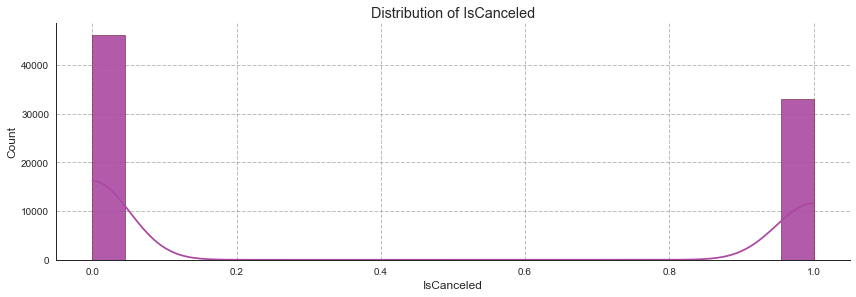

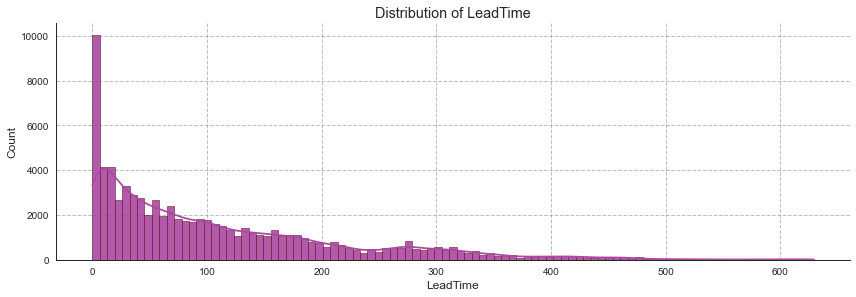

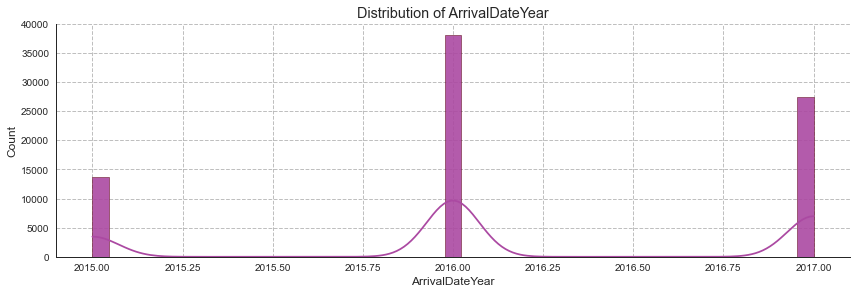

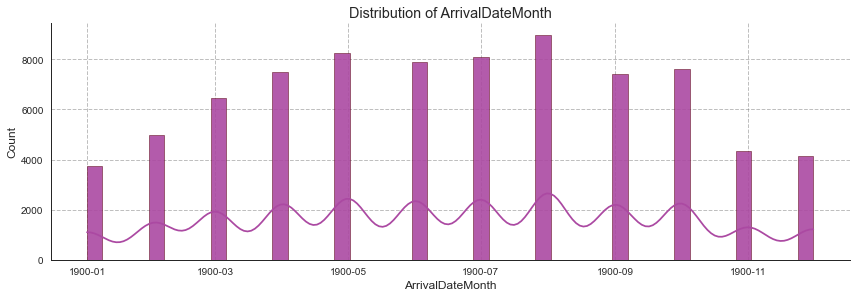

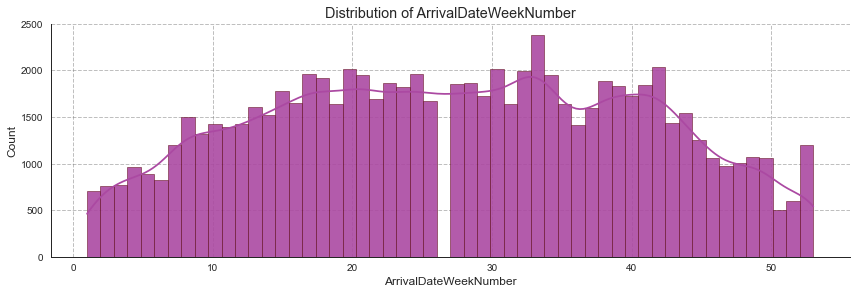

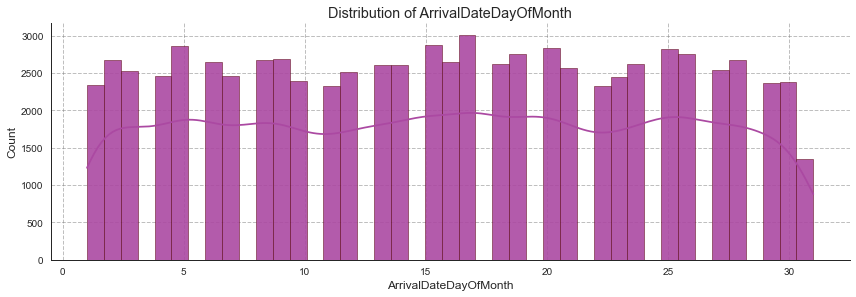

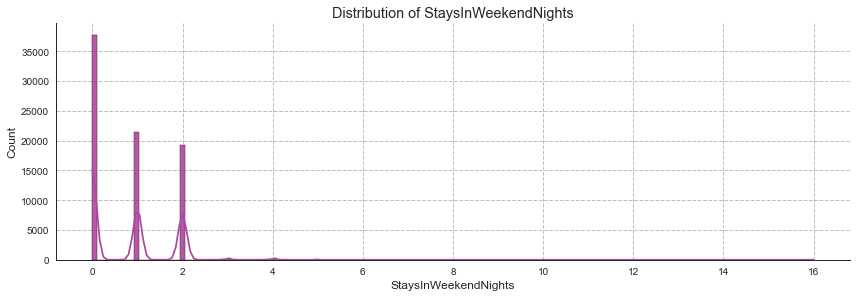

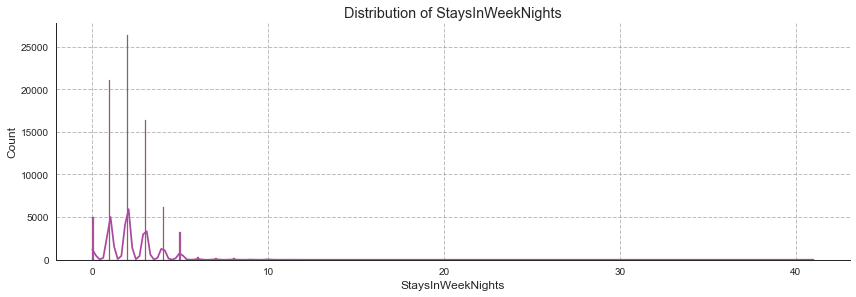

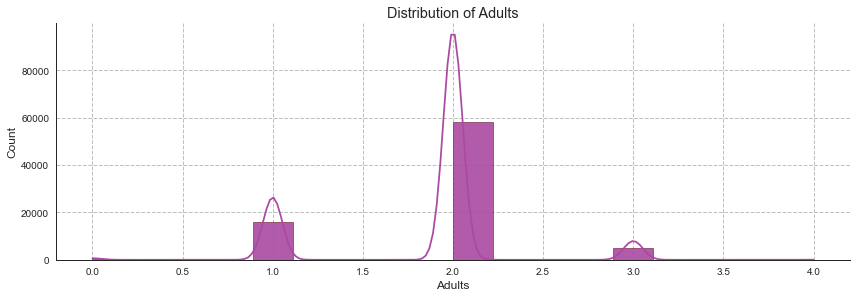

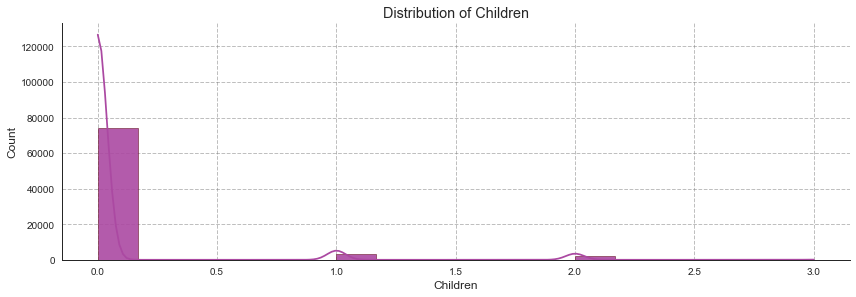

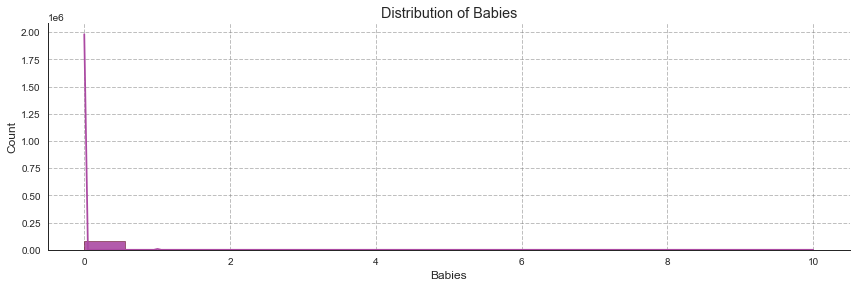

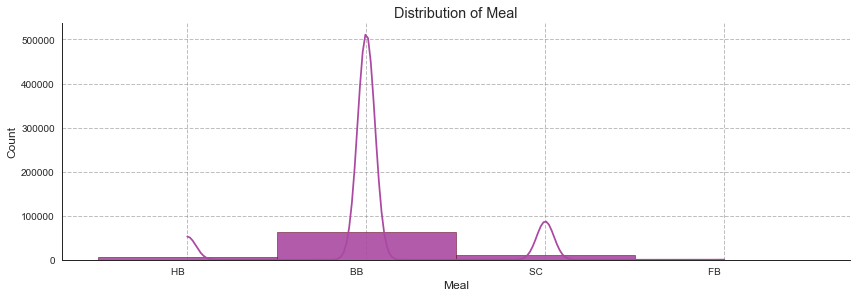

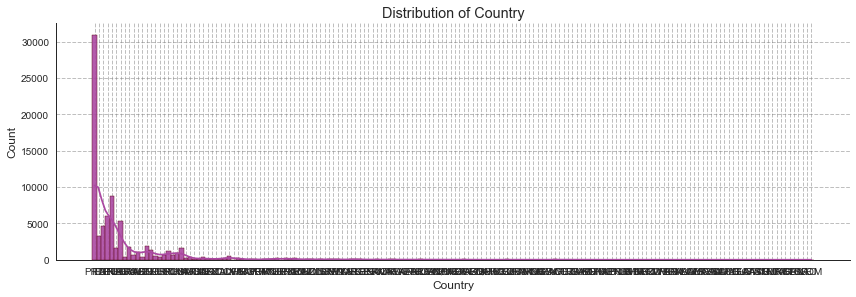

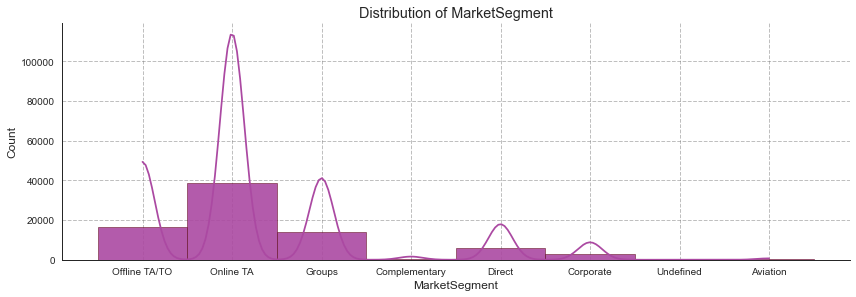

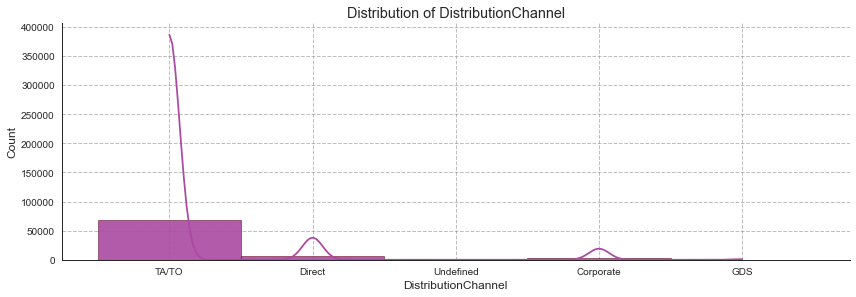

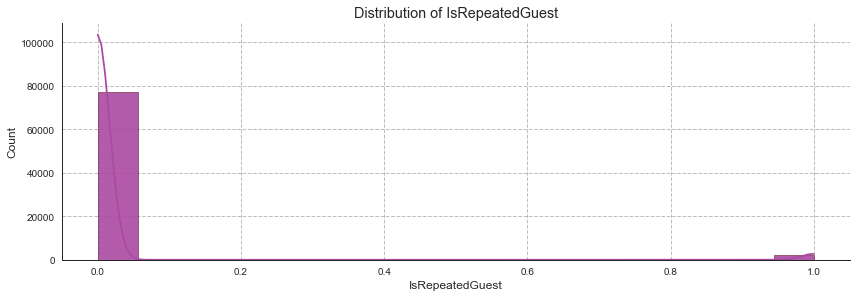

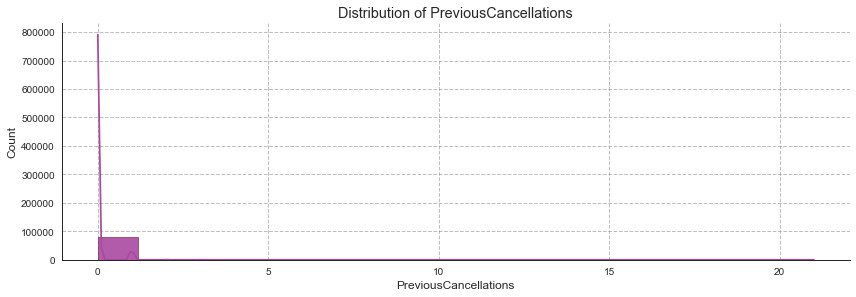

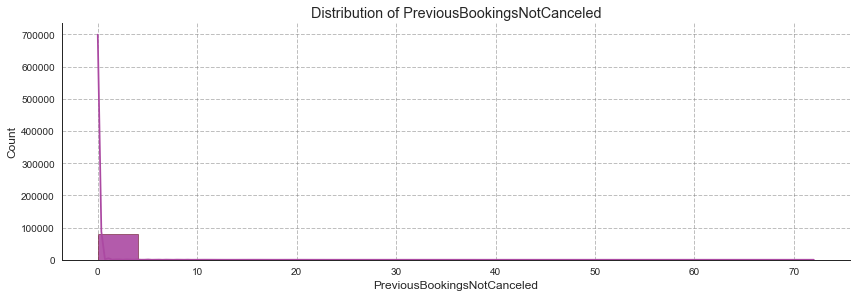

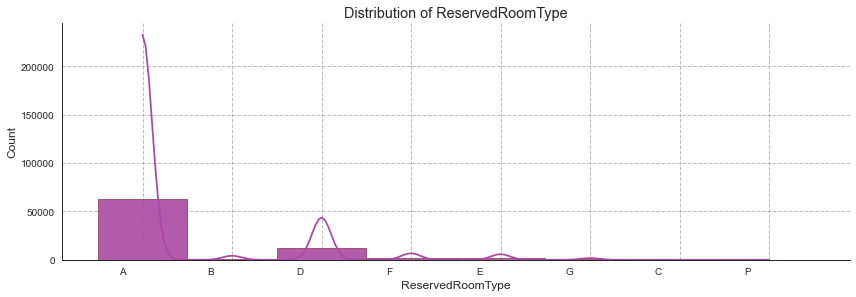

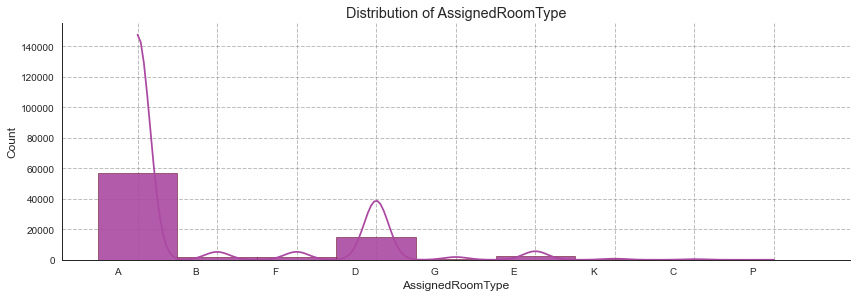

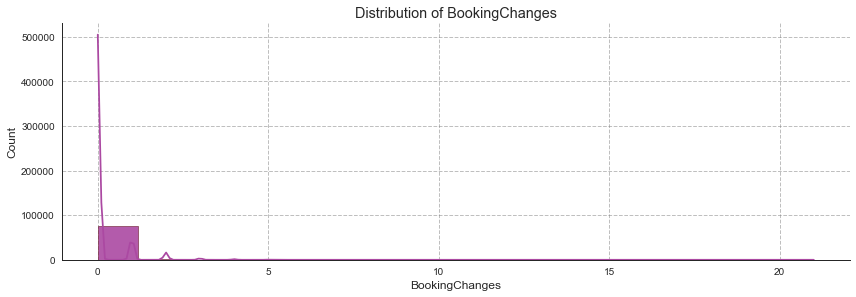

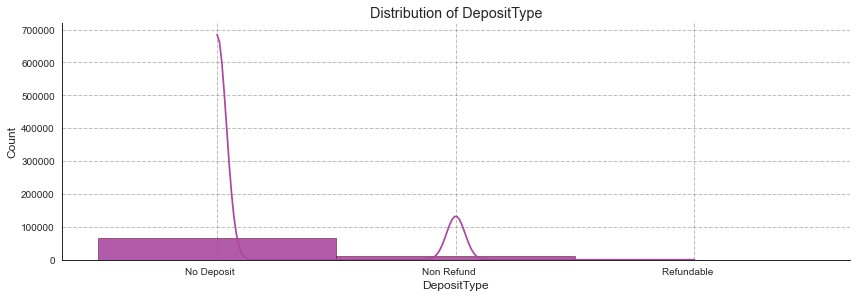

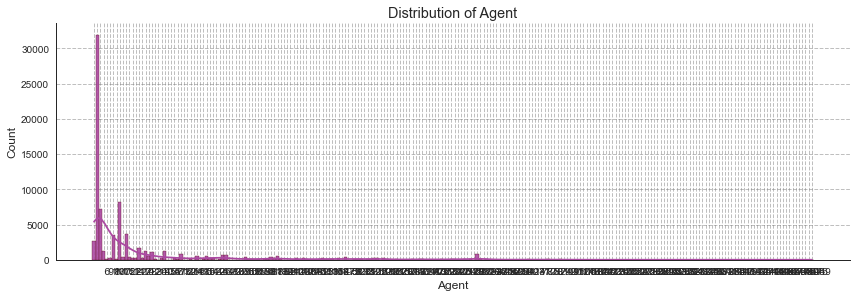

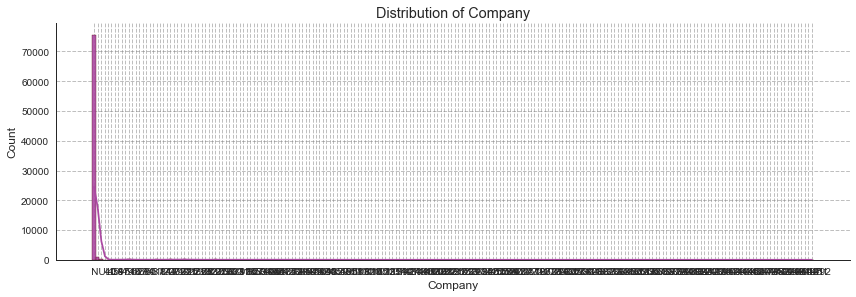

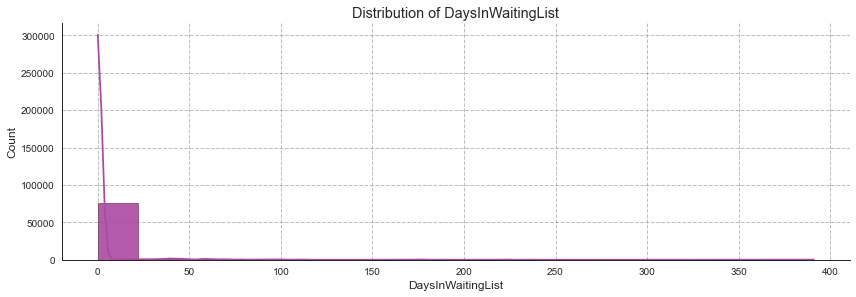

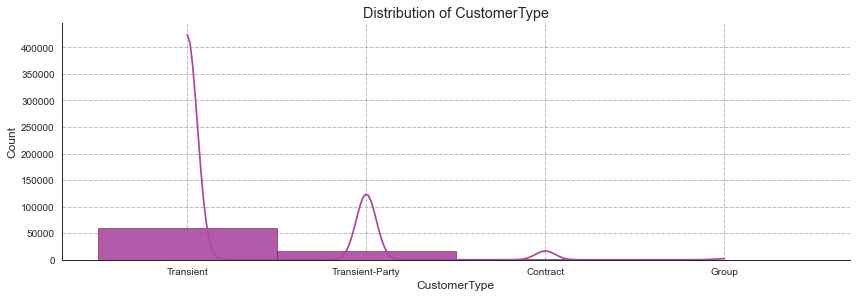

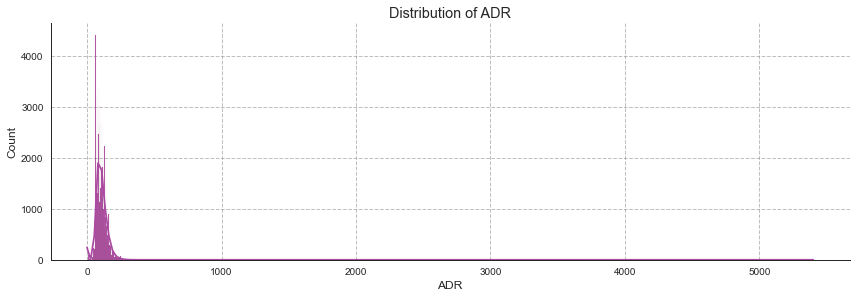

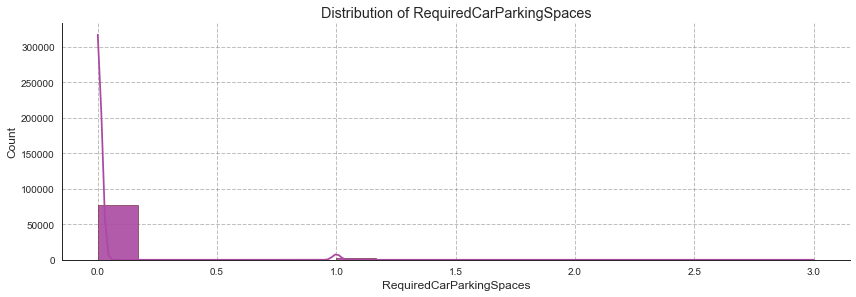

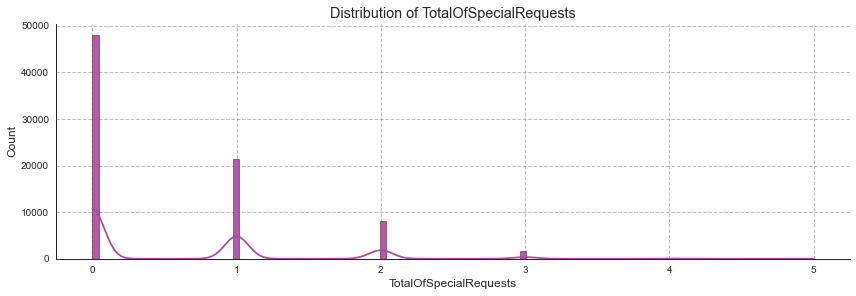

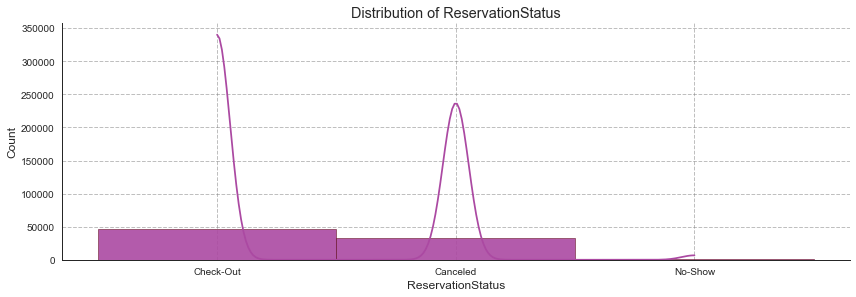

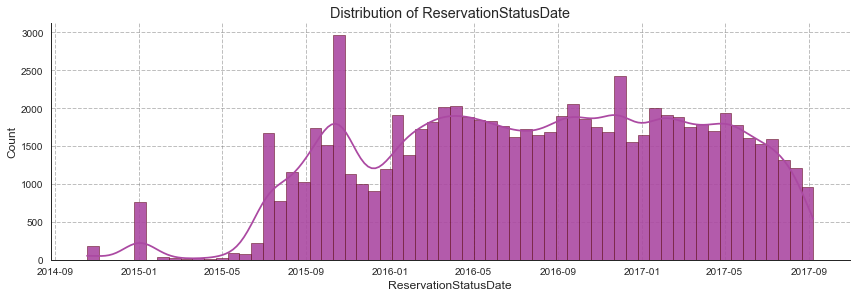

In [356]:
plot_distributions(H2)

<font color='grey'> __Notes:__ 
   
<font color='grey'> __1__ - We checked statistical values from numerical features. <p>
<font color='grey'> __2__ - We checked statistical values from catgorical features. <p>
<font color='grey'> __3__ - We analyzed categorical features' values. <p>
<font color='grey'> __4__ - We plot distributions.

### 2.4 Data Quality

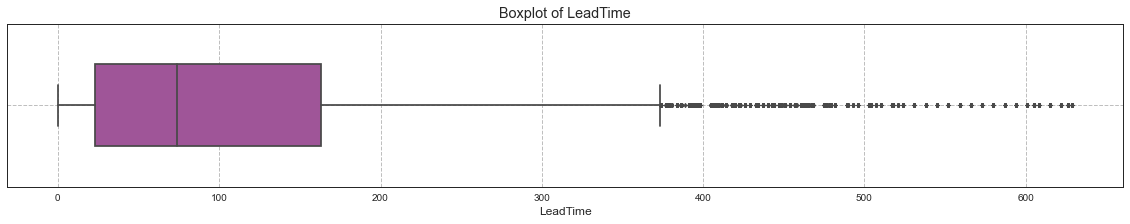

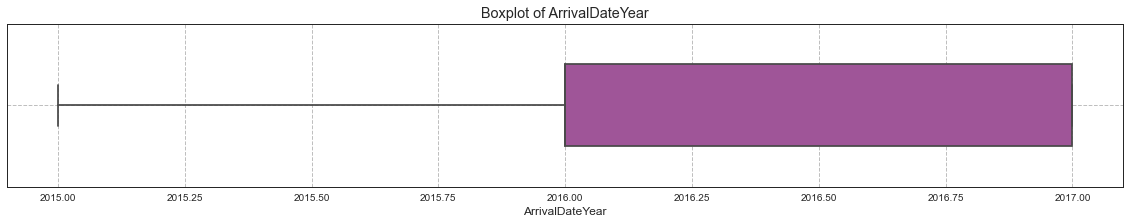

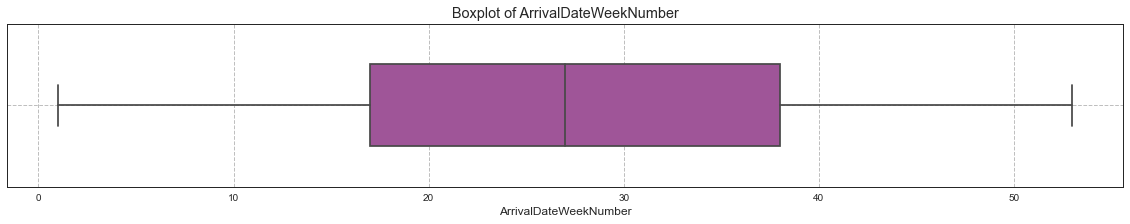

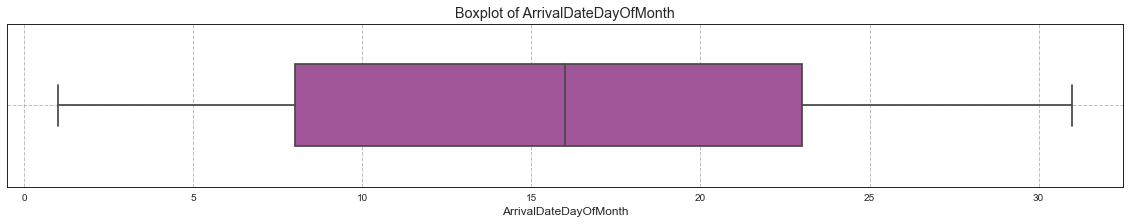

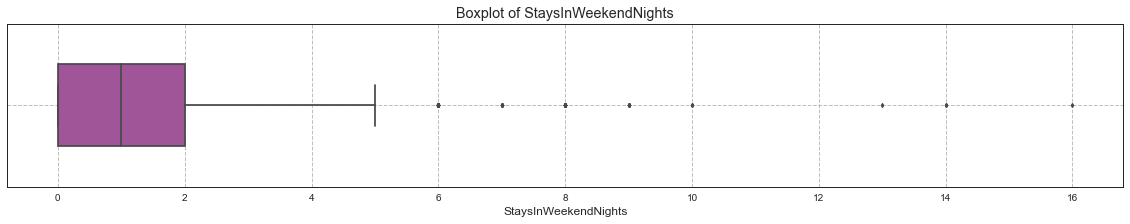

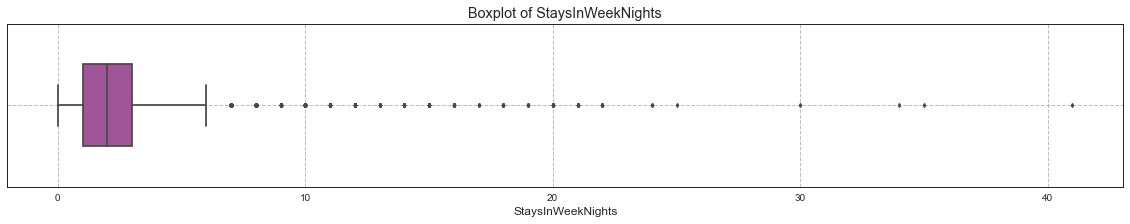

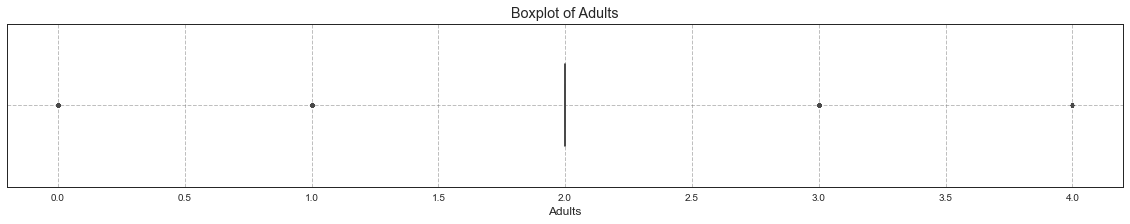

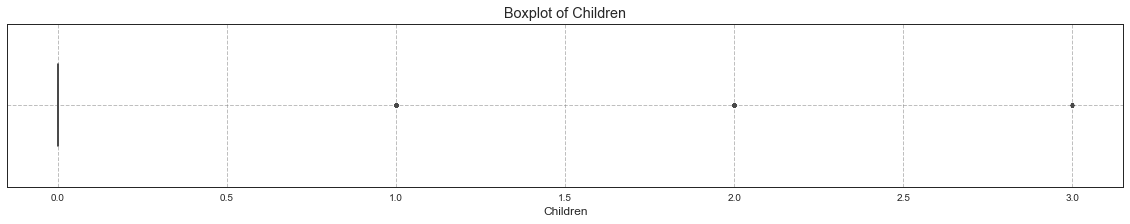

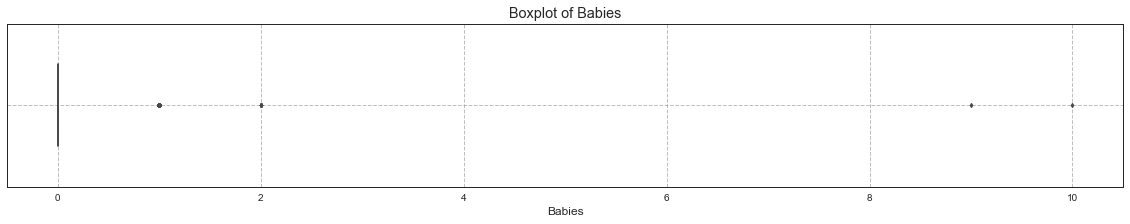

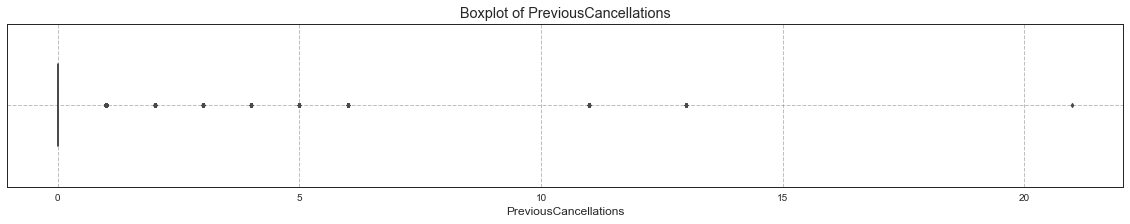

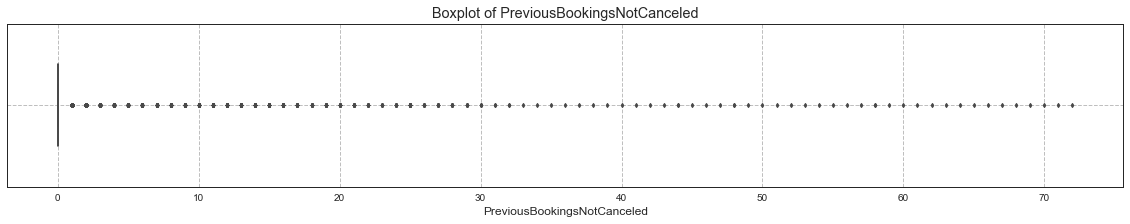

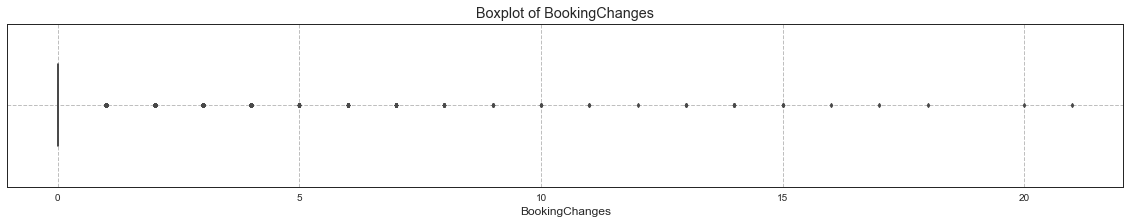

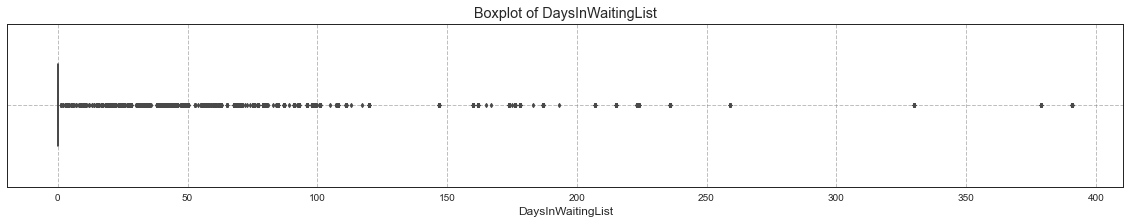

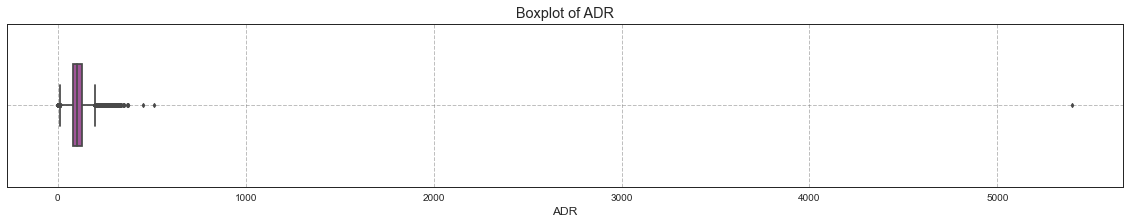

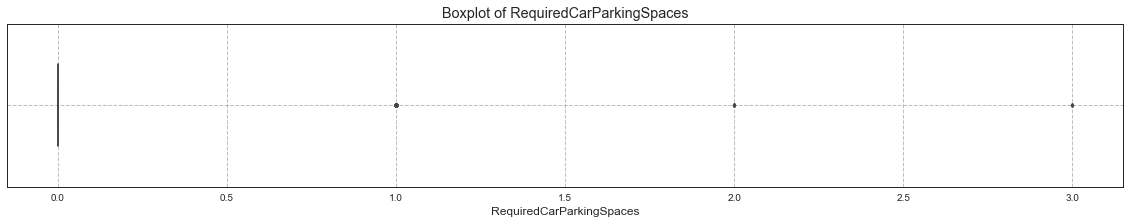

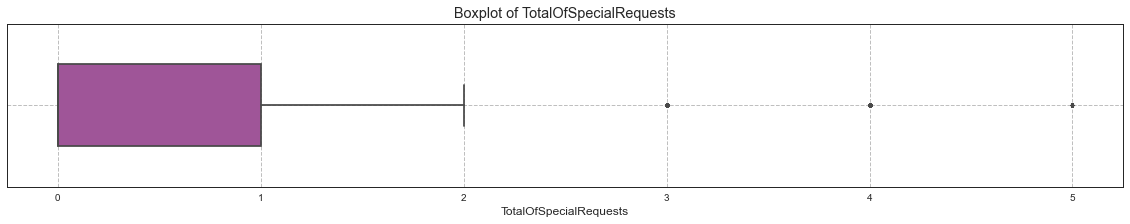

In [357]:
plot_boxplots(H2)

<font color='grey'> __Notes:__ 
   
<font color='grey'> __1__ - We coded boxplots to visualize outliers and data quality. <p>

### 2.5 Data Relationships

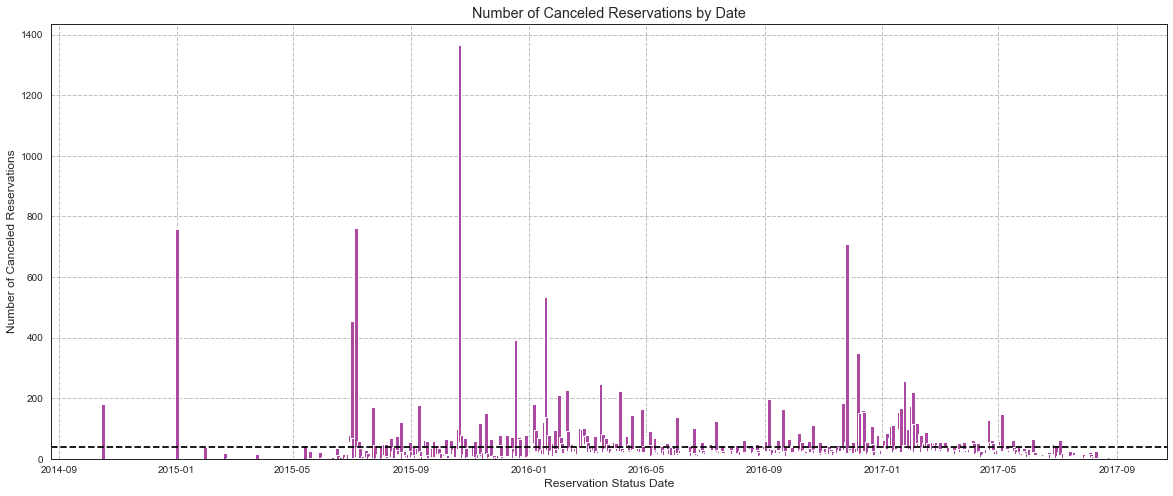

In [358]:
# Group data by ReservationStatusDate and count IsCanceled == 1
canceled_counts = H2[H2['IsCanceled'] == 1].groupby('ReservationStatusDate')['IsCanceled'].count()

# Calculate the average number of cancellations
average_cancelations = canceled_counts.mean()

# Plot the data
plt.style.use('ggplot')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(20, 8))
plt.bar(canceled_counts.index, canceled_counts.values, color='#AB49A2',width=4, linewidth=1)
plt.axhline(average_cancelations, color='black', linestyle='--', label='Average Cancellations')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.title('Number of Canceled Reservations by Date')
plt.xlabel('Reservation Status Date')
plt.ylabel('Number of Canceled Reservations')
plt.show()

In [360]:
numerical_variables = H2.select_dtypes(include='number')
numerical_variables = numerical_variables.drop(columns='IsRepeatedGuest')

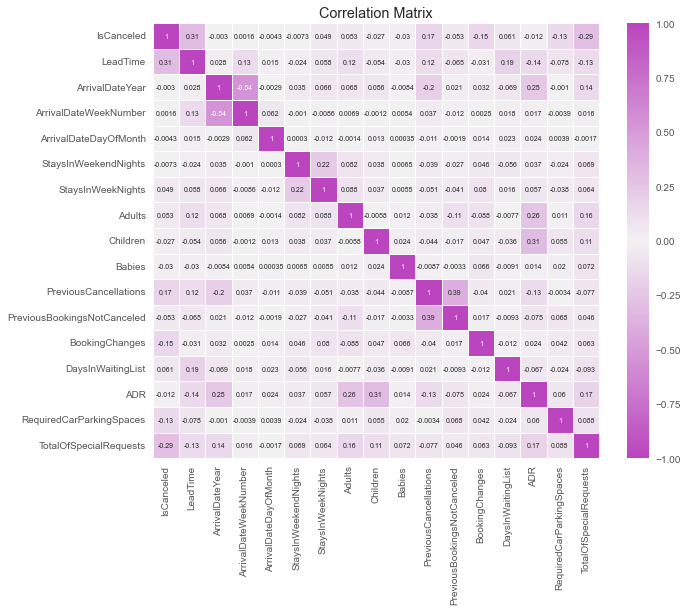

In [363]:
a = ['IsCanceled','LeadTime','ArrivalDateYear','ArrivalDateWeekNumber','ArrivalDateDayOfMonth','StaysInWeekendNights',
     'StaysInWeekNights','Adults','Children','Babies','PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges',
     'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']
plot_correlations_num(H2[a])

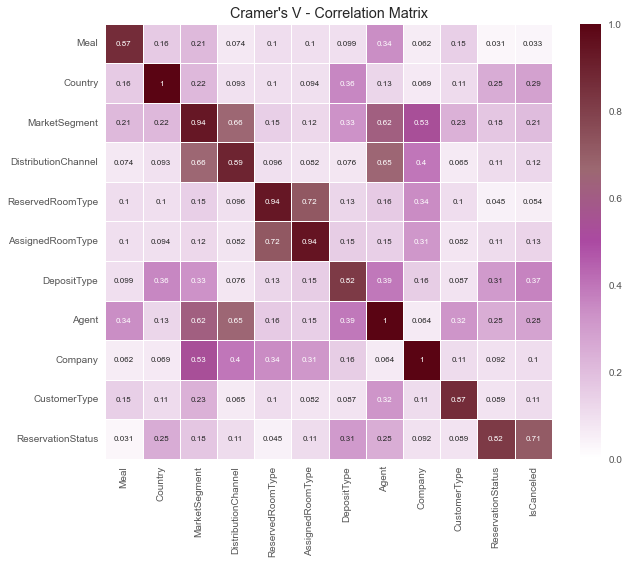

In [367]:
# Call the function to plot the correlations
plot_correlations_cat_bin(H2, 'IsCanceled')

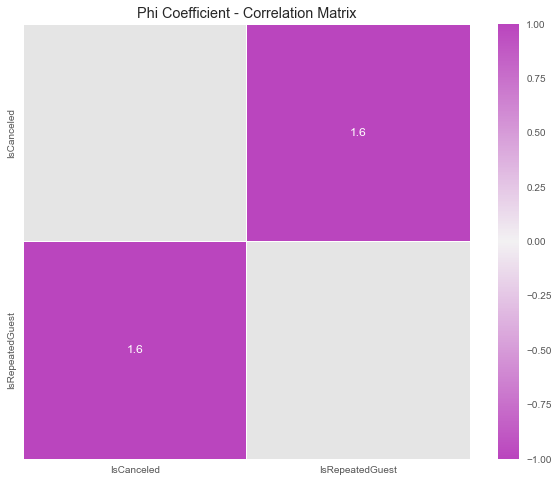

In [380]:
plot_correlations_bin_bin(H2)

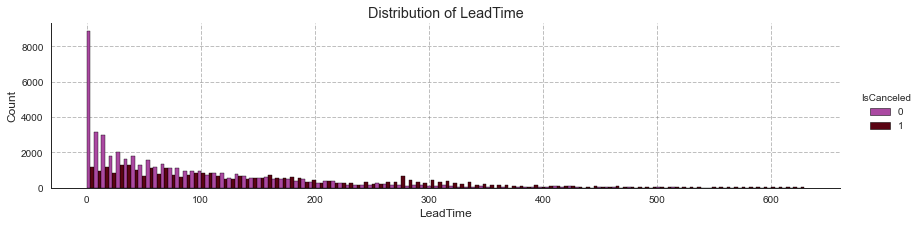

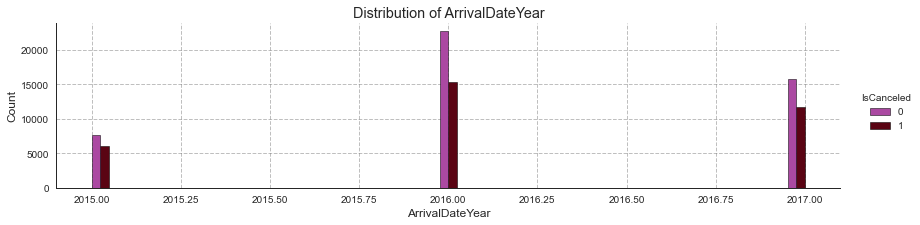

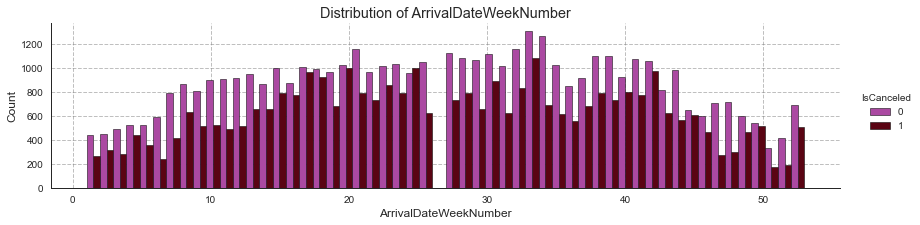

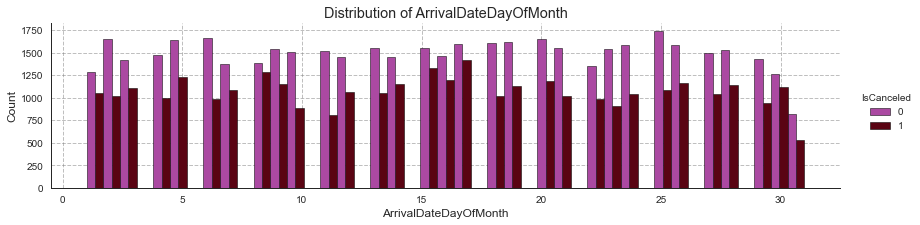

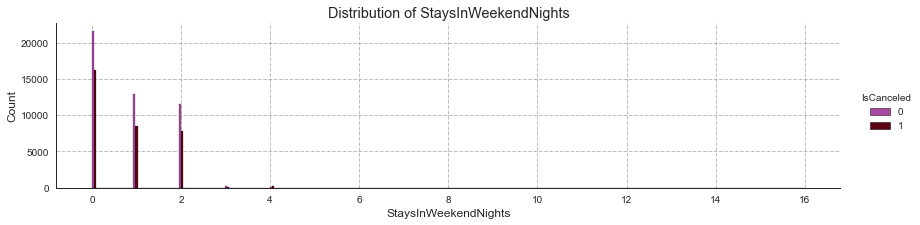

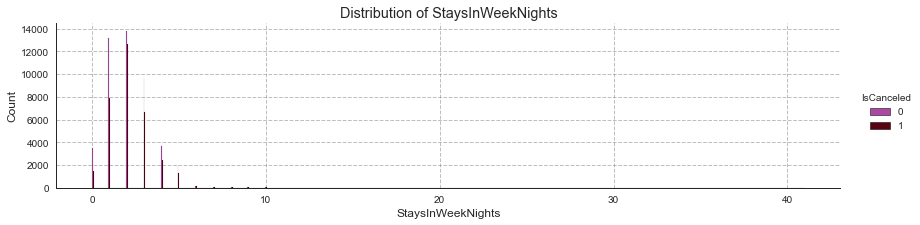

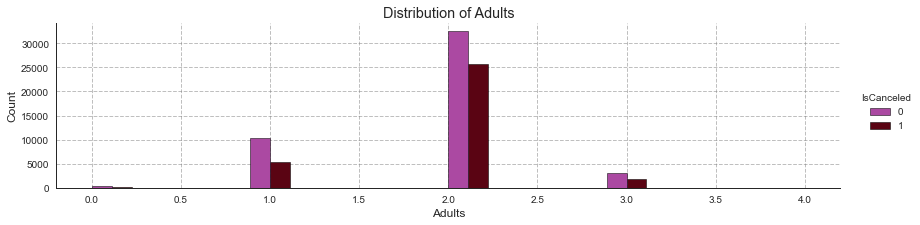

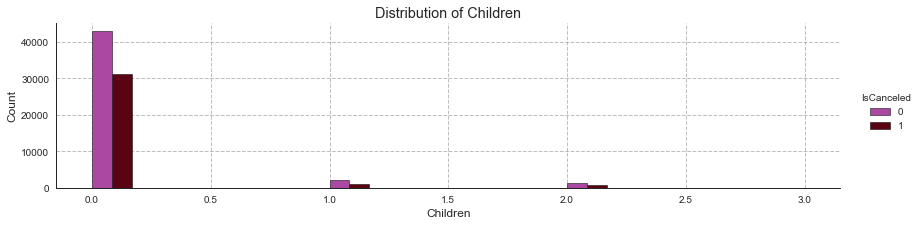

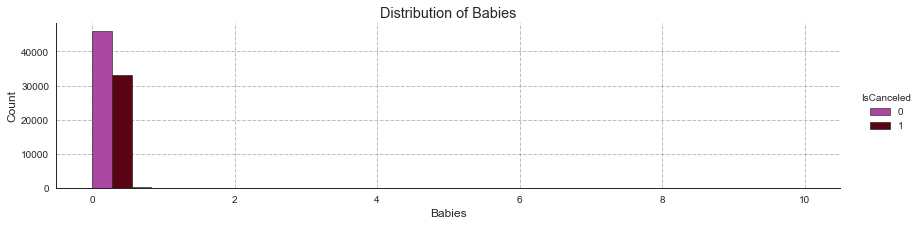

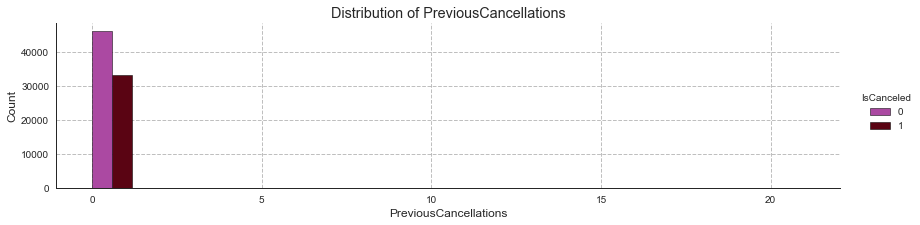

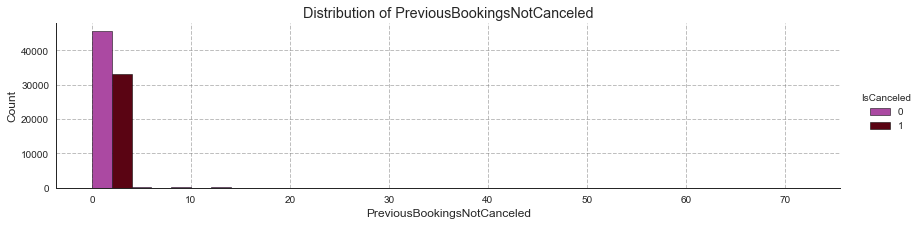

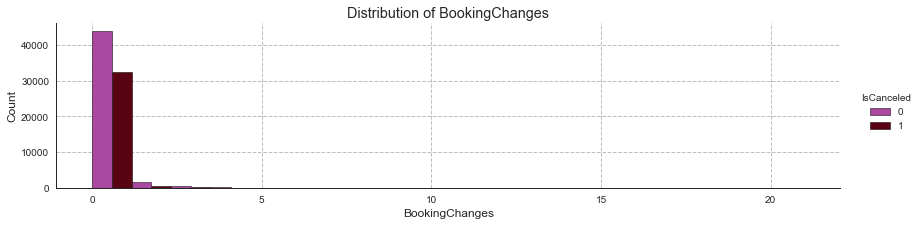

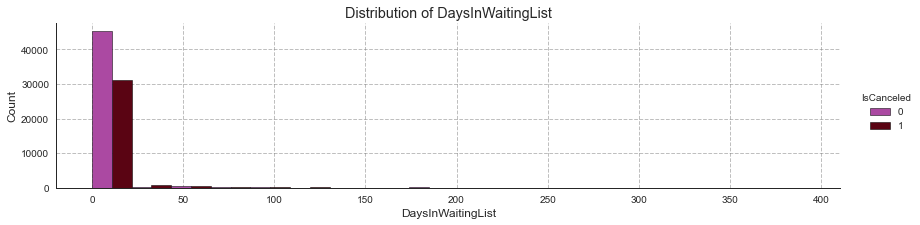

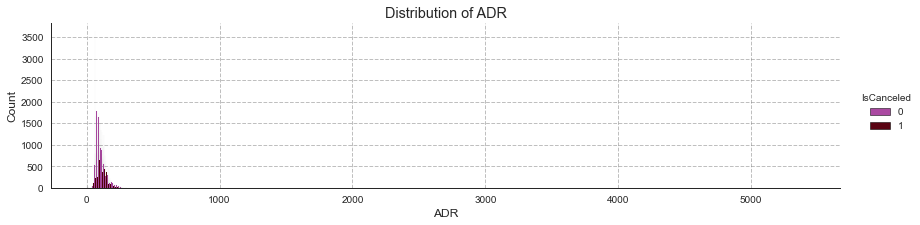

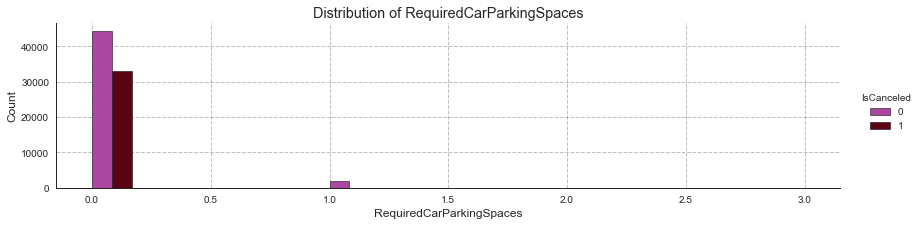

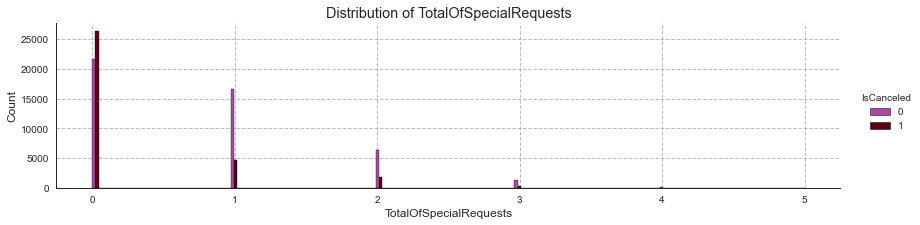

In [369]:
num_y_relationship(H2, 'IsCanceled')

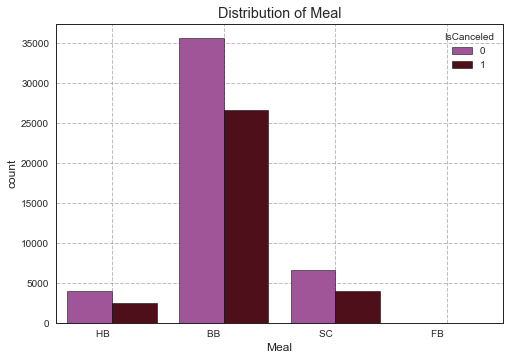

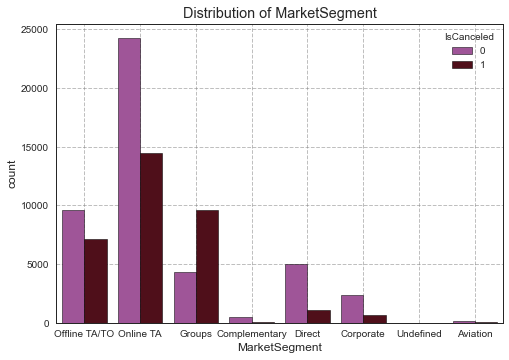

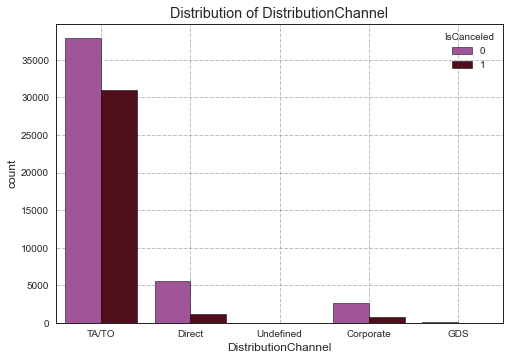

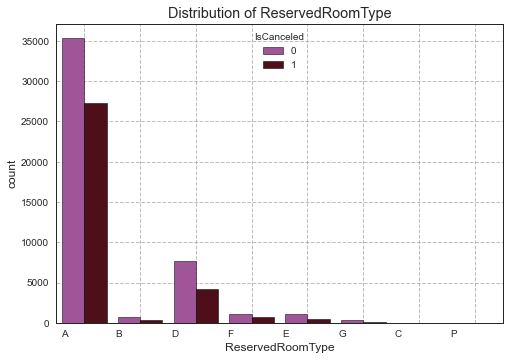

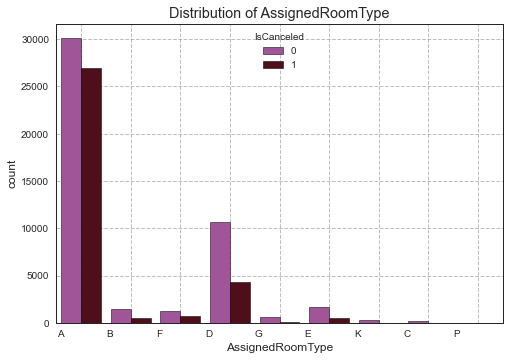

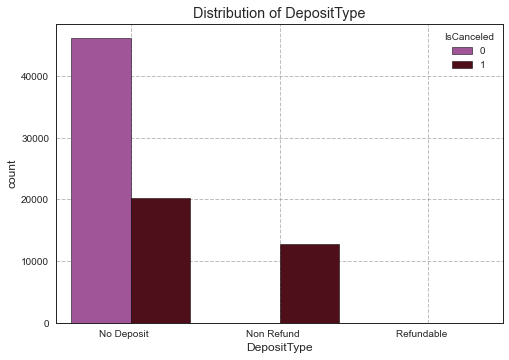

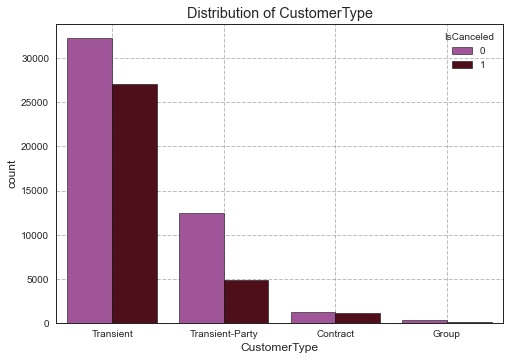

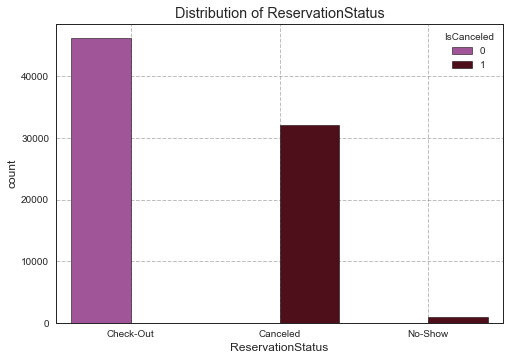

In [370]:
cat_y_relationship(H2, 'IsCanceled')

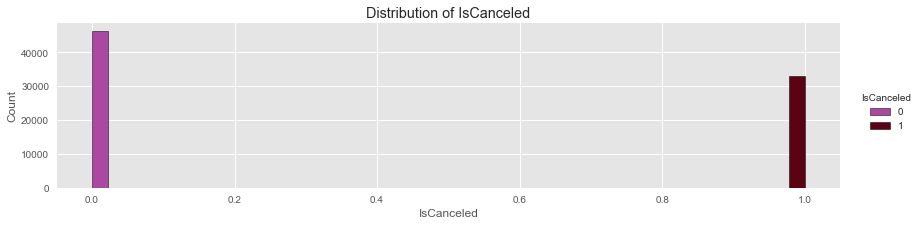

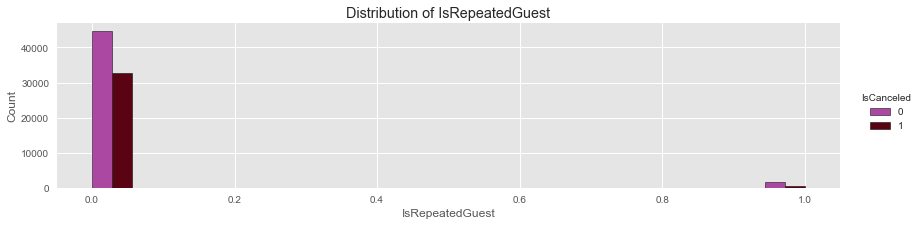

In [371]:
bin_y_relationship(H2, 'IsCanceled')

<font color='grey'> __Notes:__ 
   
<font color='grey'> __1__ - We analyzed the number of cancelations per day. <p>
<font color='grey'> __2__ - We analyzed correlations. <p>
<font color='grey'> __3__ - We analyzed the relationship between numerical features and the target value ('IsCanceled'). <p>
<font color='grey'> __3__ - We analyzed the relationship between categorical features and the target value ('IsCanceled'). <p>
<font color='grey'> __3__ - We analyzed the relationship between binary features and the target value ('IsCanceled').    

## <font color='SeaGreen'>3. Data Preparation</font>

<font color='SeaGreen'> __Cleanse, transform, and format the data to prepare it for analysis. This may involve data cleaning, feature engineering, and data integration.__

### 3.1 Data Cleaning

In [381]:
# Drop Missing values once its only in two features DocIDHash and Age
H2.dropna(inplace=True)
H2.drop_duplicates(inplace=True)
H2_copy=H2

In [382]:
H2.shape

(53418, 31)

In [383]:
dfiqr15=H2
dfiqr3=H2
dfz=H2
percentage_remaining_data_IQR(dfiqr15, 1.5) #moderated outliers
percentage_remaining_data_IQR(dfiqr3, 3) #severe outliers
percentage_remaining_data_Zscore(dfz, 3) #z-score

48 % data kept using IQR
51 % data kept using IQR
85 % data kept using Z-score


In [384]:
# Remove customers with
data = H2[(H2['StaysInWeekendNights'] < 11) & 
          (H2['LeadTime'] < 550) &
          (H2['StaysInWeekNights'] < 30) &
          (H2['Babies'] < 8) &
          (H2['DaysInWaitingList'] < 300) &
          (H2['ADR'] < 1000)
          ]

 # Print the percentage of customers remaining
print('After excluding the outliers manually,',
          f'the dataset will remain with \033[1m{np.round((len(data)/len(H2))*100, 3)}',
          '%\033[0m of its original Customers')

print(data.shape)

After excluding the outliers manually, the dataset will remain with 99.916 % of its original Customers
(53373, 31)


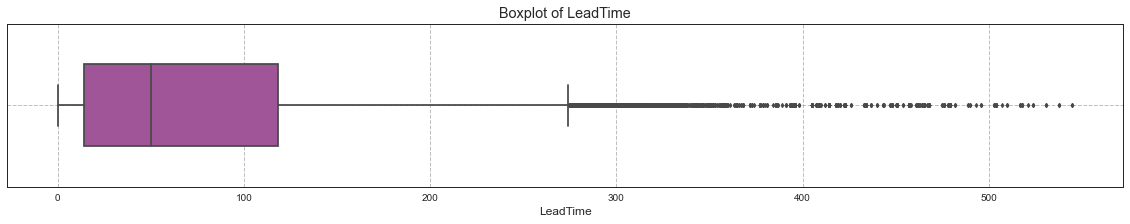

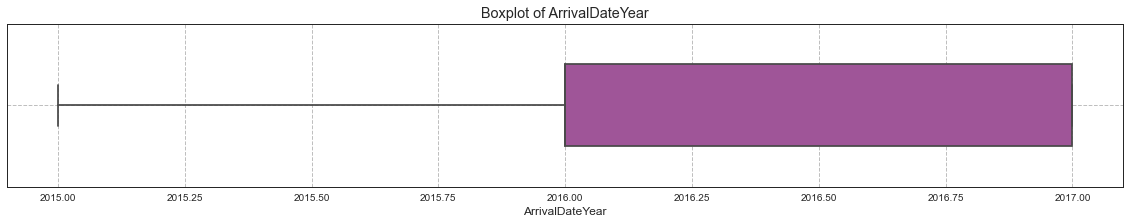

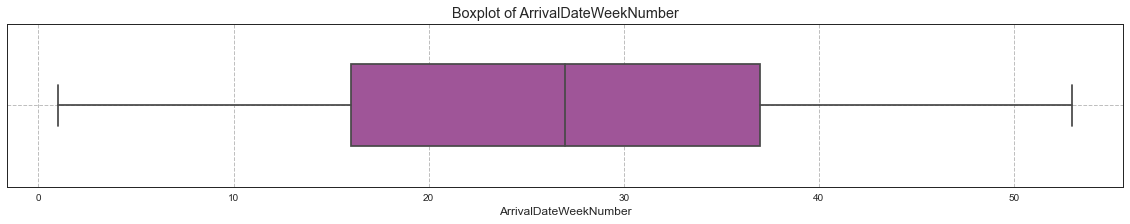

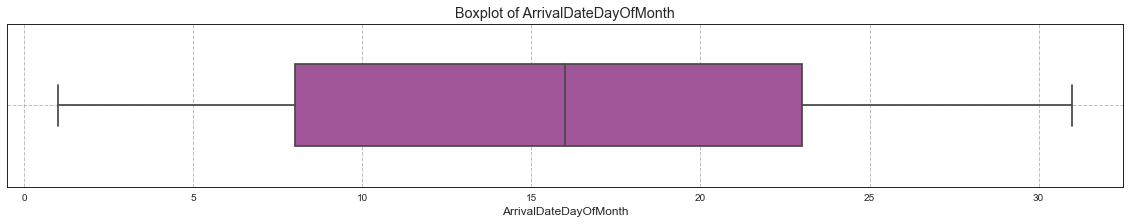

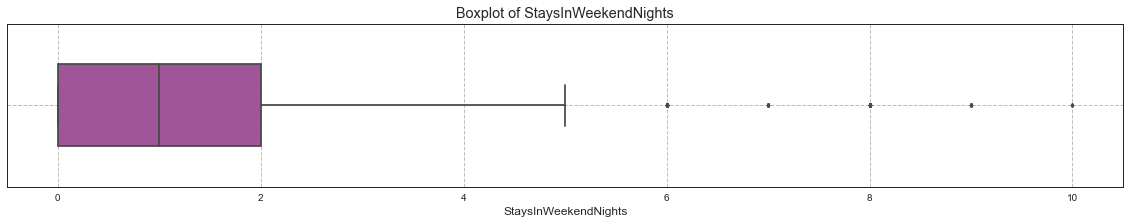

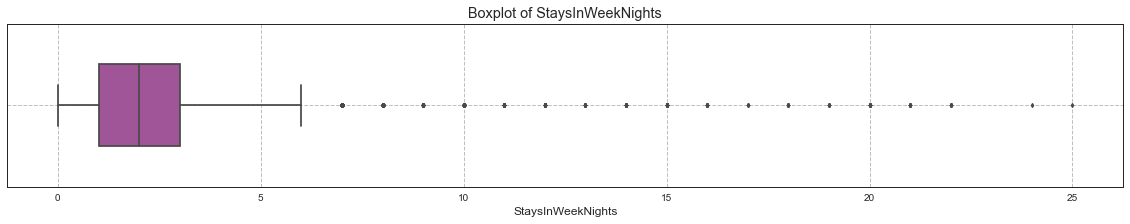

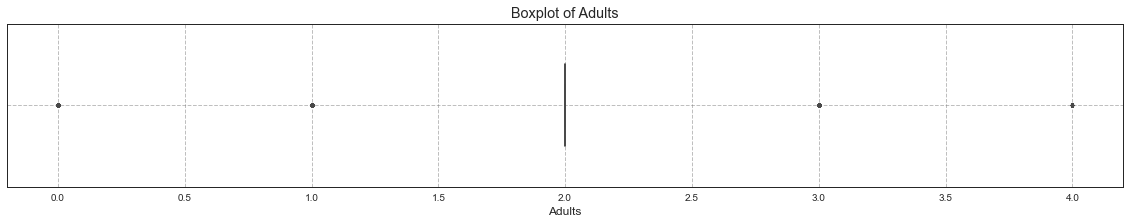

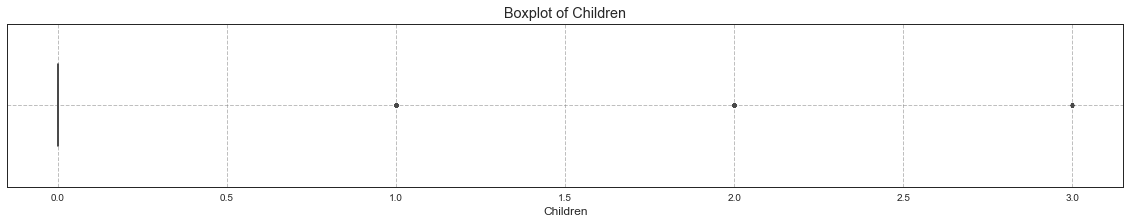

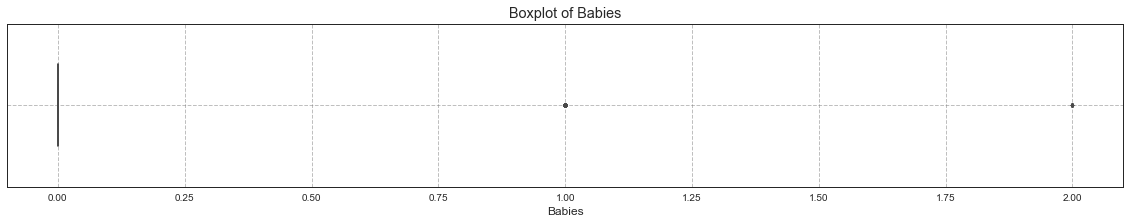

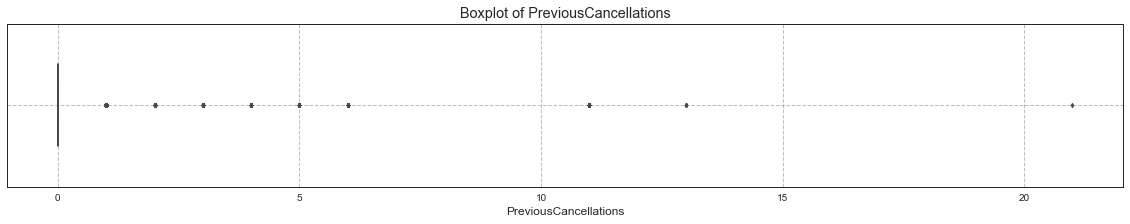

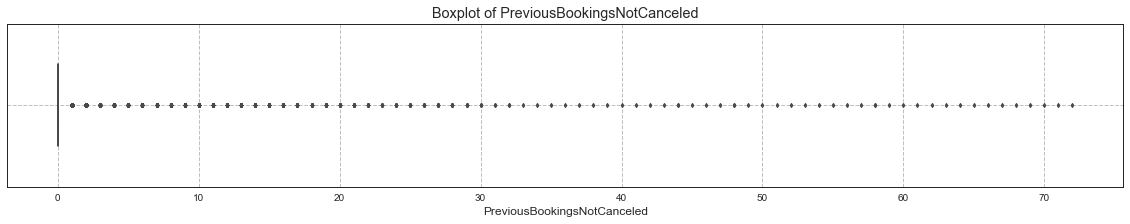

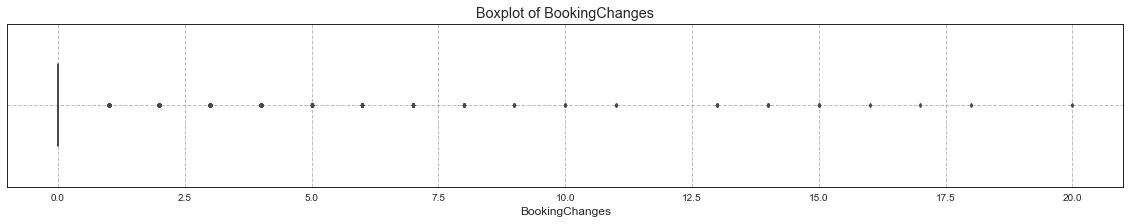

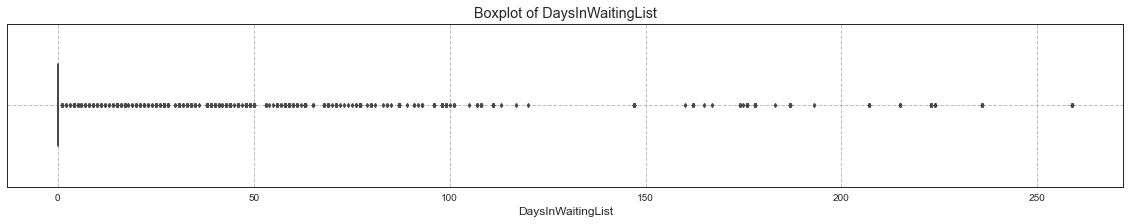

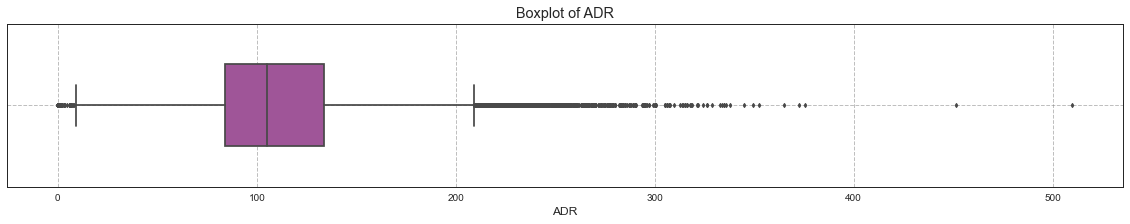

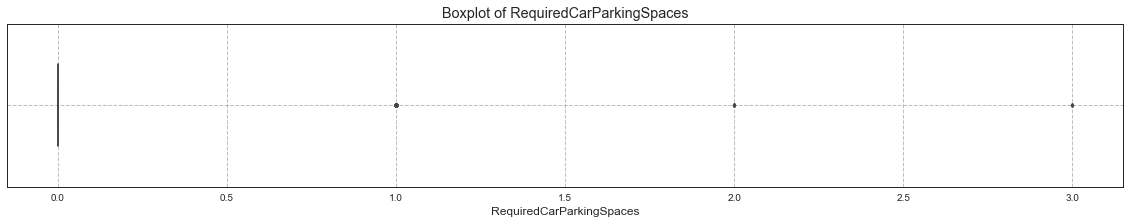

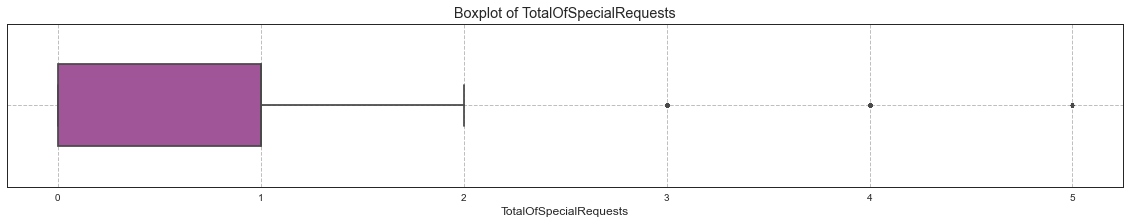

In [385]:
plot_boxplots(data)

<font color='grey'> __Notes:__ 

<font color='grey'> __1__ - We __droped missing values__ <p>
<font color='grey'> __2__ - We __checked the percentage of data remaining after removing outliers__, using the method:
- __IQR (thresold=1.5) Data remained was 48%__
- __IQR (thresold=3) Data remained was 51%__
- __Z-score (thresold=3) Data remained was 85%__ <p>

<font color='grey'> __3__ - __Once no method had the desired performance__ (removing only >10% of the dataframe), __we applied manual outlier removal__:
- __StaysInWeekendNights__ (<11)
- __LeadTime__ (<550)
- __StaysInWeekNights__ (<30)
- __Babies__ (<8)
- __DaysInWaitingList__ (<300)
- __ADR__ (<1000)
    <p>

### 3.2 Feature Engineering

In [386]:
# check categorical columns with more than 11 unique values
cat_cols10 = []
for col in data.select_dtypes(include=['object', 'category']).columns:
    if data[col].nunique() > 10:
        cat_cols10.append(col)
print(cat_cols10)

['Country', 'Agent', 'Company']


In [387]:
data = pd.merge(data, Regions, left_on='Country', right_on='ISO-alpha3 Code')
data.drop(['ISO-alpha3 Code'], axis=1, inplace=True)
data = data.rename(columns={'Sub-region Name': 'Region'})

#Reducing division of Regions by relevancy

data['Region'] = data['Region'].replace(['Polynesia'], 'Oceania')
data['Region'] = data['Region'].replace(['Micronesia'], 'Oceania')
data['Region'] = data['Region'].replace(['Melanesia'], 'Oceania')
data['Region'] = data['Region'].replace(['Western Asia'], 'Western and Central Asia')
data['Region'] = data['Region'].replace(['Central Asia'], 'Western and Central Asia')
data['Region'] = data['Region'].replace(['Southern Asia'], 'Southern and Eastern Asia')
data['Region'] = data['Region'].replace(['South-eastern Asia'], 'Southern and Eastern Asia')
data['Region'] = data['Region'].replace(['Eastern Asia'], 'Southern and Eastern Asia')
data['Region'] = data['Region'].replace(['Sub-Saharan Africa'], 'Africa')
data['Region'] = data['Region'].replace(['Northern Africa'], 'Africa')
data['Region'] = data['Region'].replace(['Australia and New Zealand'], 'Oceania')
data['Region'] = data['Region'].replace(['Oceania'], 'Asia and Oceania')
data['Region'] = data['Region'].replace(['Western and Central Asia'], 'Asia and Oceania')
data['Region'] = data['Region'].replace(['Southern and Eastern Asia'], 'Asia and Oceania')

data_Region_counts = pd.DataFrame(data['Region'].value_counts())
# reset the index and rename columns
data_Region_counts = data_Region_counts.reset_index()
data_Region_counts.columns = ['Region', 'Count']
data_Region_counts

,Region,Count
0,Southern Europe,19930
1,Western Europe,17127
2,Northern Europe,7312
3,Asia and Oceania,2554
4,Latin America and the Caribbean,2061
5,Eastern Europe,1584
6,Northern America,1416
7,Africa,856


In [388]:
missing_value_reporter(data, threshold=0.005)

,Feature,Nº of missings,% of missings,Above threshold
Region,Region,2,0.0,False


In [389]:
data.dropna(inplace=True)

In [390]:
# Extract the year, month, and day features from the 'date' column
data['ReservationStatusYear'] = data['ReservationStatusDate'].dt.year.astype(int)
data['ReservationStatusMonth'] = data['ReservationStatusDate'].dt.month.astype(int)
data['ReservationStatusDay'] = data['ReservationStatusDate'].dt.day.astype(int)

In [391]:
data = data.drop(columns=['Agent', 'Company','Country','ArrivalDateMonth','ReservationStatusDate','ReservationStatus'])

In [392]:
data = data.replace('       ', '', regex=True)
data = data.replace('                ', '', regex=True)

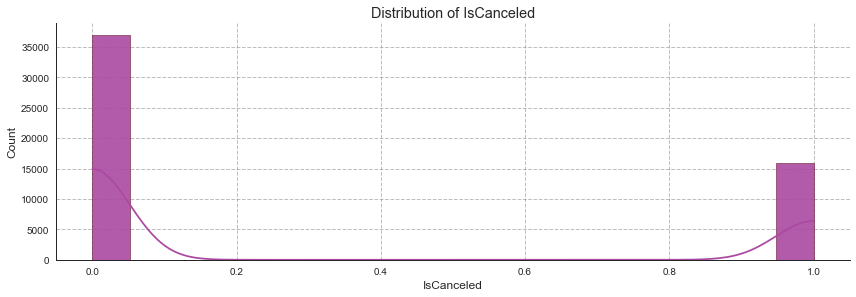

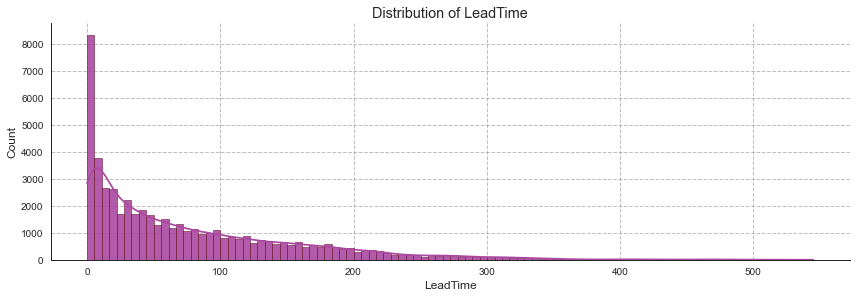

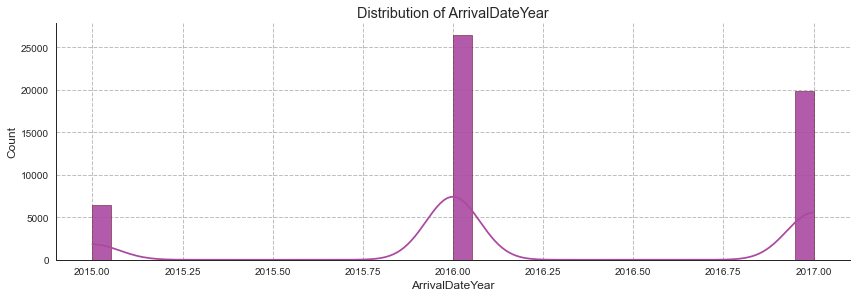

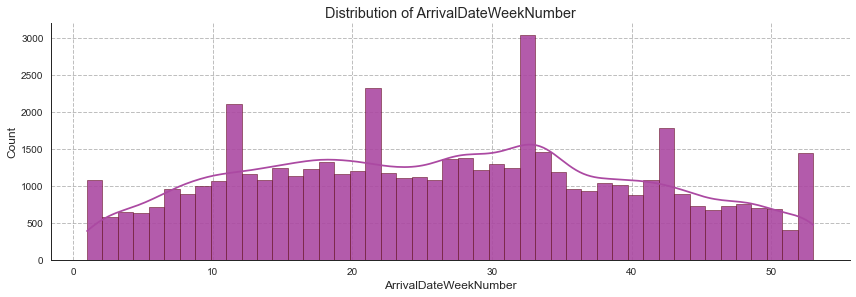

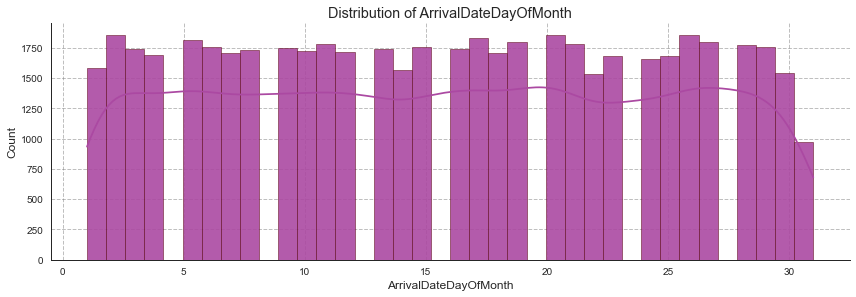

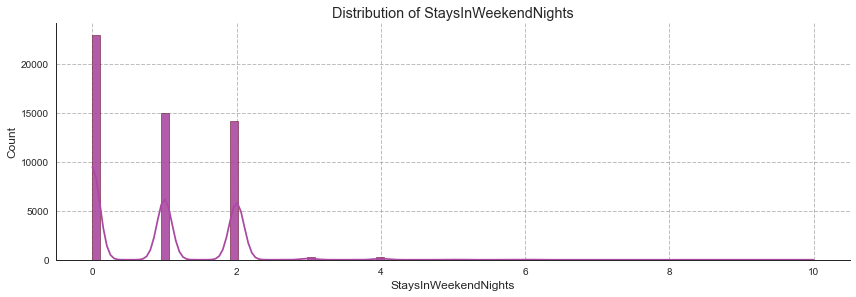

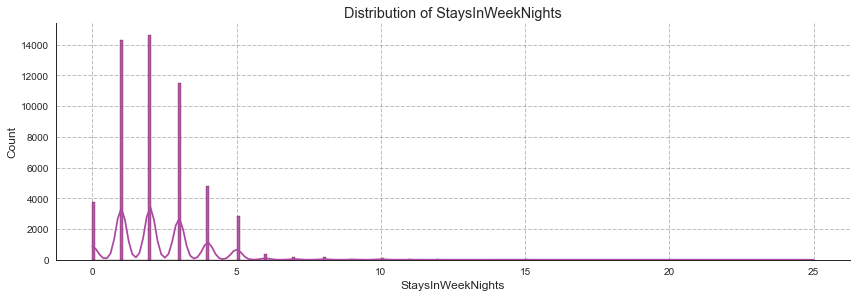

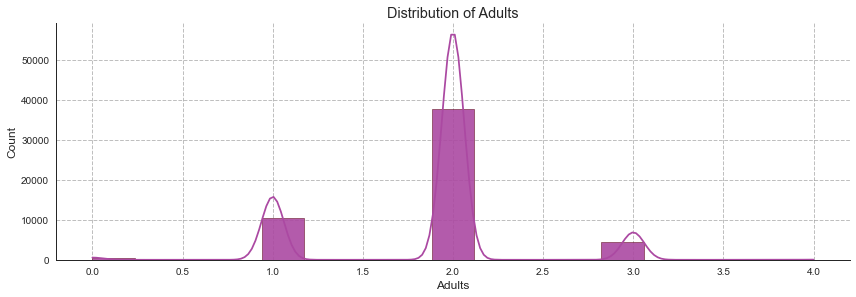

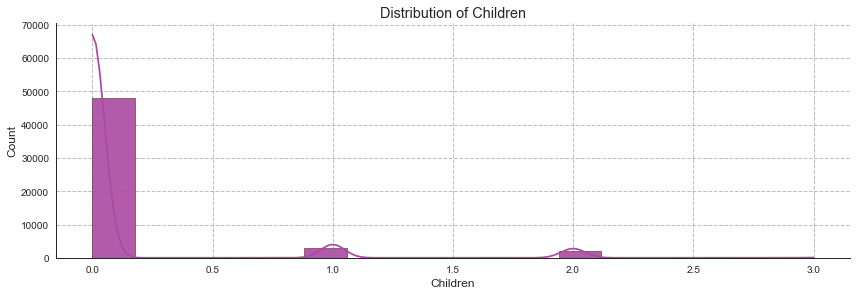

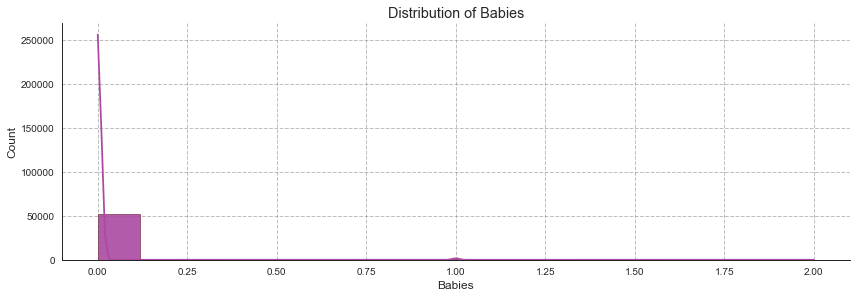

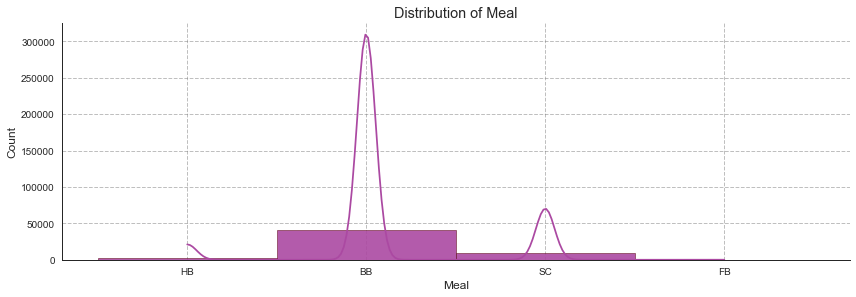

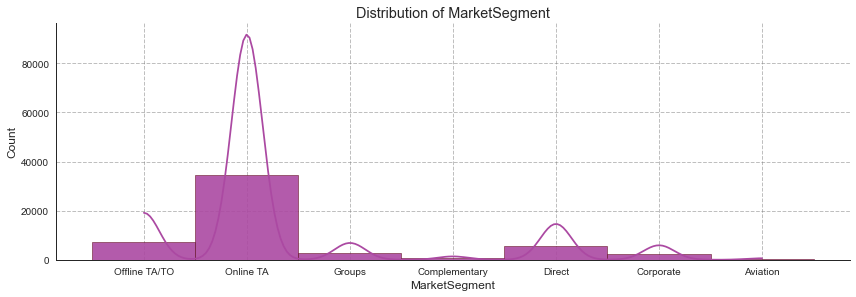

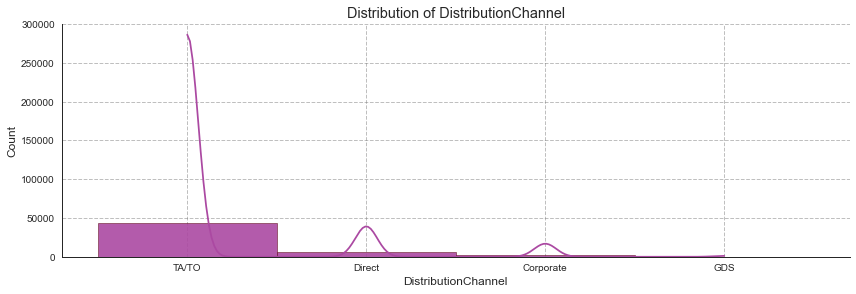

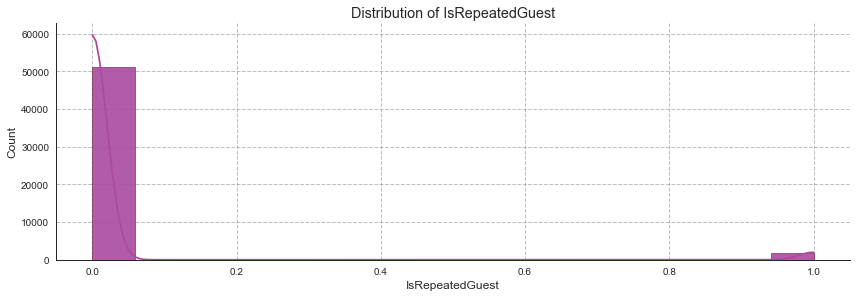

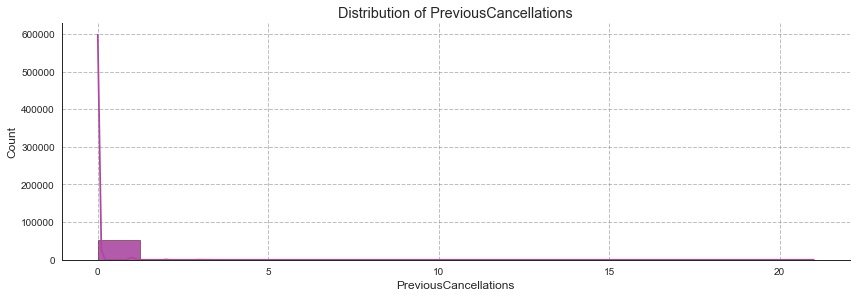

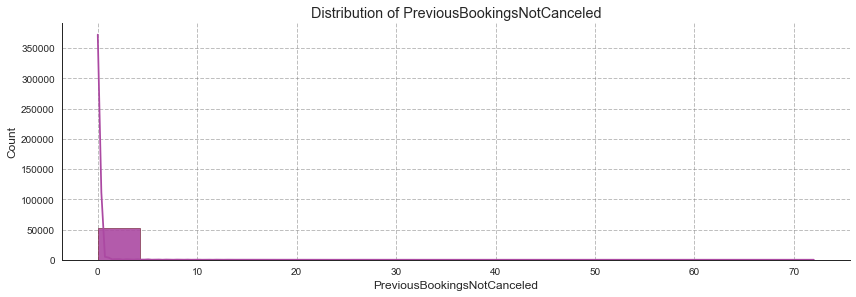

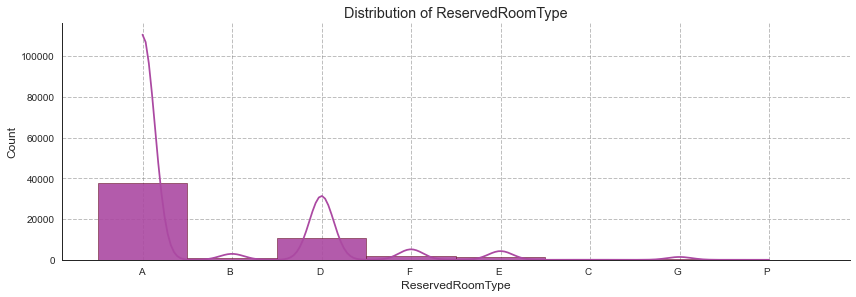

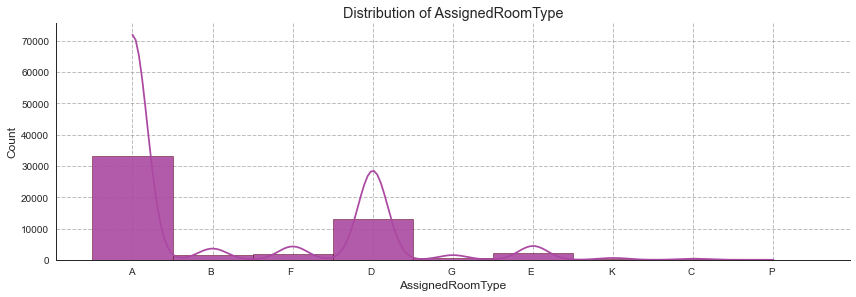

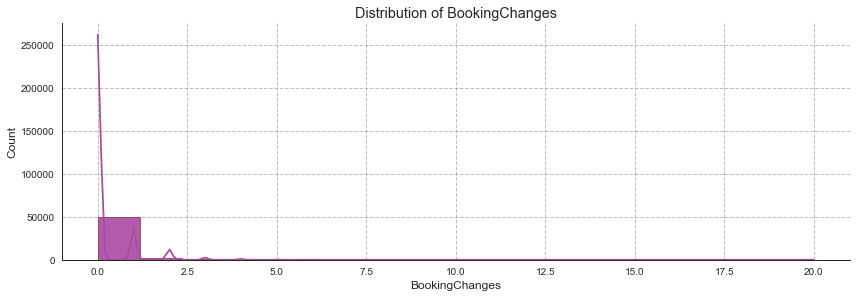

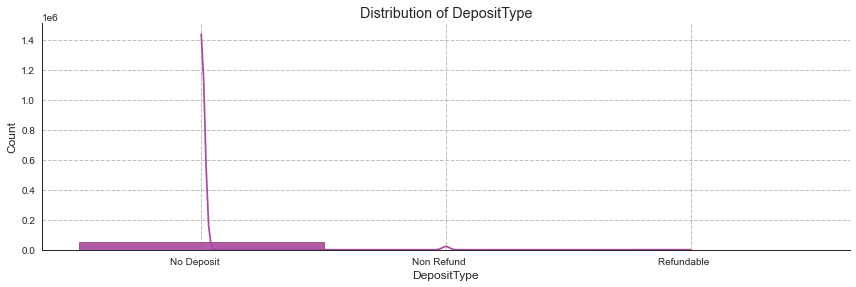

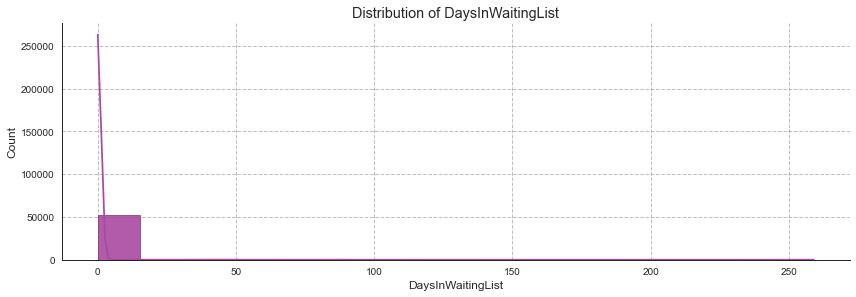

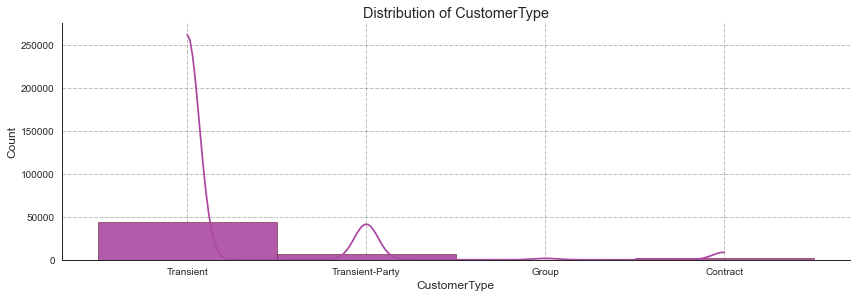

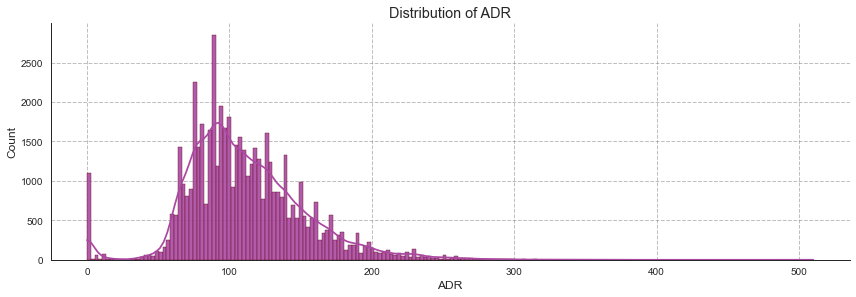

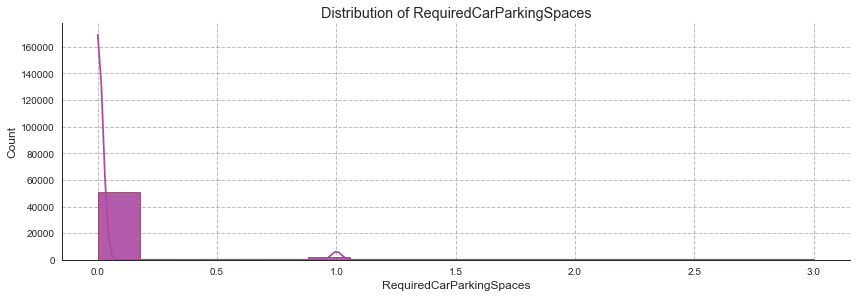

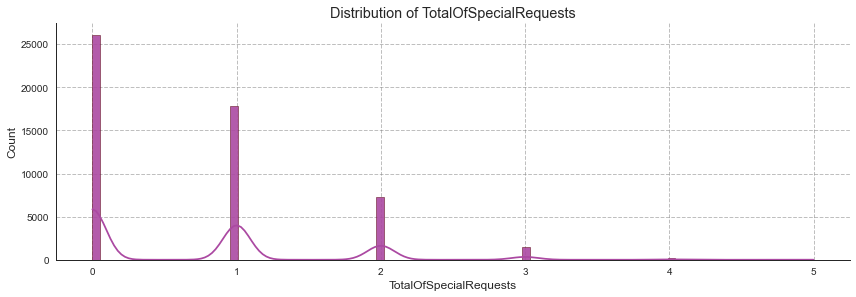

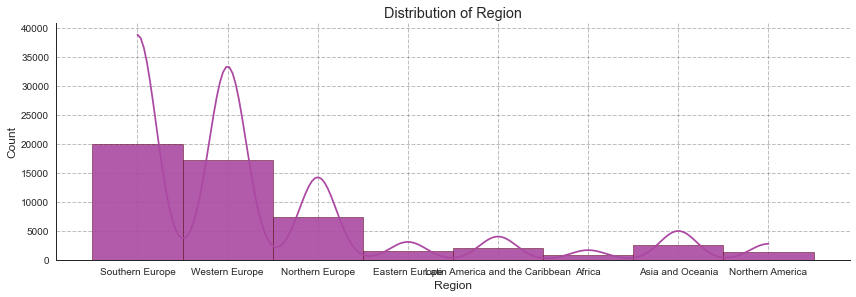

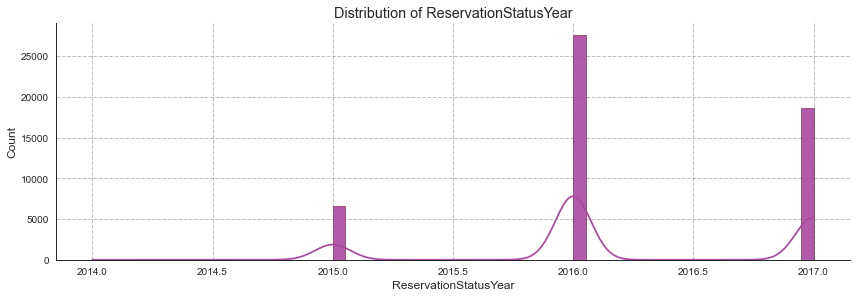

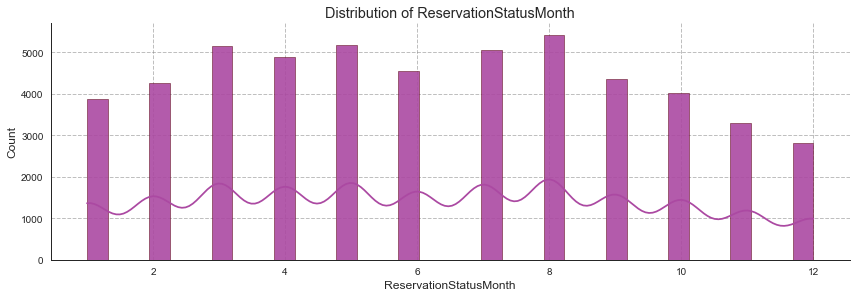

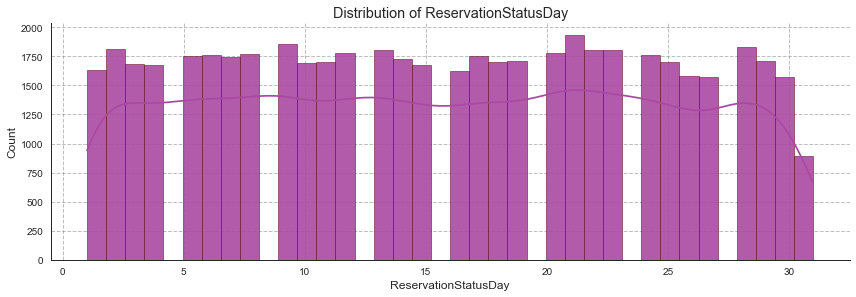

In [393]:
plot_distributions(data)

<font color='grey'> __Notes:__ 
   
<font color='grey'> __1__ - We checked categorical variables with more than 11 values. <p>
<font color='grey'> __2__ - 'Country' is a feature with more than 11 values so we agreggate it into bins 'Regigons'. <p>
<font color='grey'> __3__ - We drop other useless categorical features with >11 values. <p> 

### 3.3 Data Split

In [394]:
# splitting target from other variables
X = data.drop('IsCanceled',axis=1)
y = data['IsCanceled']

# Setting random states seed
seed = 999

# Splitrin the data, leaving 20% in the hold out sample
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    random_state = seed,
                                                    shuffle = True,
                                                    stratify = y,
                                                    test_size = 0.15,
                                                   )

# Further splitting the training data into training and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.18, random_state=seed, stratify=y_train
)


print('train: \033[1m{}%\033[0m | val: \033[1m{}%\033[0m | test: \033[1m{}%\033[0m'.format(
    round(len(y_train)/len(y)*100), round(len(y_val)/len(y)*100), round(len(y_test)/len(y)*100)
))

train: 70% | val: 15% | test: 15%


In [395]:
print('X_train shape is:','rows',X_train.shape[0],'columns',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train shape is: rows 36829 columns 28
X_val shape is: rows 8085 columns 28
X_test shape is: rows 7926 columns 28 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


In [396]:
#Split into numerical and categorical
X_train_num = X_train.select_dtypes(include=np.number)
X_train_cat = X_train.select_dtypes(exclude=np.number)

X_val_num = X_test.select_dtypes(include=np.number)
X_val_cat = X_test.select_dtypes(exclude=np.number)

X_test_num = X_test.select_dtypes(include=np.number)
X_test_cat = X_test.select_dtypes(exclude=np.number)

In [397]:
print('X_train shape is:','rows',X_train.shape[0],'columns',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train shape is: rows 36829 columns 28
X_val shape is: rows 8085 columns 28
X_test shape is: rows 7926 columns 28 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


### 3.4 Feature Selection

In [398]:
#RFE
selected_RFE = select_features_rfe(X_train_num, y_train, 15, 1)
print(selected_RFE)

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'PreviousCancellations', 'BookingChanges', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ReservationStatusYear', 'ReservationStatusMonth',
       'ReservationStatusDay'],
      dtype='object')


In [399]:
#Lasso
selected_Lasso = select_features_lasso(X_train_num, y_train)
print(selected_Lasso)

['LeadTime', 'DaysInWaitingList', 'ADR', 'ReservationStatusMonth']


In [400]:
#Spearman
selected_spearman = select_features_spearman(X_train_num, y_train, 15)
print(selected_spearman)

['LeadTime' 'PreviousCancellations' 'ADR' 'StaysInWeekNights' 'Adults'
 'ArrivalDateYear' 'StaysInWeekendNights' 'Children' 'DaysInWaitingList'
 'ArrivalDateDayOfMonth' 'ReservationStatusYear' 'ArrivalDateWeekNumber'
 'ReservationStatusDay' 'Babies' 'IsRepeatedGuest']


In [401]:
#Chi-Square
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Meal is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
Region is IMPORTANT for Prediction


In [402]:
# create an empty DataFrame with columns
columns = ['Predictor', 'RFE', 'Lasso', 'Spearman']
df_num = pd.DataFrame(columns=columns)

# fill the DataFrame
for i in range(len(X_train_num.columns)):
    predictor = X_train_num.columns[i]
    rfe_bool = predictor in selected_RFE
    lasso_bool = predictor in selected_Lasso
    spearman_bool = predictor in selected_spearman
    
    # create a dictionary with values
    row_dict = {'Predictor': predictor, 'RFE': rfe_bool, 'Lasso': lasso_bool, 'Spearman': spearman_bool}
    
    # append the dictionary as a new row to the DataFrame
    df_num = df_num.append(row_dict, ignore_index=True)

# create a copy of the DataFrame with green highlights for True values
num_df_styled = df_num.style.applymap(lambda x: 'background-color : green' if x else '', 
                              subset=df_num.columns[1:])

In [403]:
# create empty dataframe with desired columns
cat_df = pd.DataFrame(columns=['Predictor', 'Chi-Square', 'P-value', 'Important'])

# loop through categorical features
for col in X_train_cat.columns:
    # calculate chi-square test for independence
    chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))
    # determine if feature is important based on p-value
    if p < 0.05:
        important = True
    else:
        important = False
    # add row to dataframe
    cat_df = cat_df.append({'Predictor': col, 'Chi-Square': chi2, 'P-value': p, 'Important': important}, ignore_index=True)

# apply styling based on important column
cat_df_styled = cat_df.style.applymap(lambda x: 'background-color: green' if x == True else '', subset=['Important'])

In [404]:
num_df_styled_styler = num_df_styled.set_table_attributes("style='display:inline'").set_caption('num_df_styled')
cat_df_styled_styler = cat_df_styled.set_table_attributes("style='display:inline'").set_caption('cat_df_styled')

html_code = num_df_styled_styler._repr_html_() + cat_df_styled_styler._repr_html_()
html_code_with_spacing = f"<div style='text-align:center;'>{html_code}</div>"
display(HTML(html_code_with_spacing))

,Predictor,RFE,Lasso,Spearman
0,LeadTime,True,True,True
1,ArrivalDateYear,True,False,True
2,ArrivalDateWeekNumber,True,False,True
3,ArrivalDateDayOfMonth,True,False,True
4,StaysInWeekendNights,True,False,True
5,StaysInWeekNights,True,False,True
6,Adults,True,False,True
7,Children,False,False,True
8,Babies,False,False,True
9,IsRepeatedGuest,False,False,True


In [405]:
discard_num_1 = df_num[df_num.iloc[:, 1:].sum(axis=1) < 1]['Predictor'].tolist()
discard_num_2 = df_num[df_num.iloc[:, 1:].sum(axis=1) < 2]['Predictor'].tolist()
discard_num_3 = df_num[df_num.iloc[:, 1:].sum(axis=1) < 3]['Predictor'].tolist()
print(len(discard_num_1))
print(len(discard_num_2))
print(len(discard_num_3))

1
7
18


In [406]:
# dropping not important features
X_train.drop(discard_num_2, axis=1, inplace=True)
X_val.drop(discard_num_2, axis=1, inplace=True)
X_test.drop(discard_num_2, axis=1, inplace=True)

In [407]:
print('X_train shape is:','rows:',X_train.shape[0],'columns:',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train shape is: rows: 36829 columns: 21
X_val shape is: rows 8085 columns 21
X_test shape is: rows 7926 columns 21 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


### 3.5 One Hot Encoding

In [408]:
cols = ['Meal',
        'MarketSegment',
        'DistributionChannel',
        'ReservedRoomType',
        'DepositType',
        'CustomerType',
        'Region',
        'AssignedRoomType']

ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)

X_train_encoded = ce_one_hot.fit_transform(X_train)
X_val_encoded = ce_one_hot.fit_transform(X_val)
X_test_encoded = ce_one_hot.fit_transform(X_test)

In [409]:
print('X_train_encoded shape is:','rows:',X_train_encoded.shape[0],'columns:',X_train_encoded.shape[1])
print('X_val_encoded shape is:','rows',X_val_encoded.shape[0],'columns',X_val_encoded.shape[1])
print('X_test_encoded shape is:','rows',X_test_encoded.shape[0],'columns',X_test_encoded.shape[1],'\n')

print('X_train shape is:','rows:',X_train.shape[0],'columns:',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train_encoded shape is: rows: 36829 columns: 60
X_val_encoded shape is: rows 8085 columns 57
X_test_encoded shape is: rows 7926 columns 58 

X_train shape is: rows: 36829 columns: 21
X_val shape is: rows 8085 columns 21
X_test shape is: rows 7926 columns 21 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


### 3.6 Feature Selection (Encoded Variables)

In [410]:
X_train_cat_encoded = ce_one_hot.fit_transform(X_train_cat)
X_val_cat_encoded = ce_one_hot.fit_transform(X_val_cat)
X_test_cat_encoded = ce_one_hot.fit_transform(X_test_cat)

In [411]:
#RFE
selected_RFE = select_features_rfe(X_train_cat_encoded, y_train, 15, 1)
print(selected_RFE,'\n')

#Lasso
selected_Lasso = select_features_lasso(X_train_cat_encoded, y_train)
print(selected_Lasso,'\n')

#Phi
selected_Phi = select_features_phi(X_train_cat_encoded, y_train, 15)
print(selected_Phi,'\n')

Index(['Meal_SC', 'MarketSegment_Online TA', 'MarketSegment_Offline TA/TO',
       'DistributionChannel_TA/TO', 'DistributionChannel_Direct',
       'ReservedRoomType_A ', 'ReservedRoomType_D ', 'AssignedRoomType_A ',
       'AssignedRoomType_D ', 'DepositType_No Deposit     ',
       'DepositType_Non Refund     ', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'Region_Southern Europe',
       'Region_Western Europe'],
      dtype='object') 

[] 

['MarketSegment_Online TA' 'DepositType_Non Refund     '
 'DepositType_No Deposit     ' 'DistributionChannel_TA/TO'
 'Region_Western Europe' 'CustomerType_Transient'
 'DistributionChannel_Direct' 'MarketSegment_Offline TA/TO'
 'CustomerType_Transient-Party' 'MarketSegment_Direct'
 'DistributionChannel_Corporate' 'Region_Southern Europe'
 'MarketSegment_Corporate' 'Meal_SC' 'Meal_BB']
['MarketSegment_Online TA' 'DepositType_Non Refund     '
 'DepositType_No Deposit     ' 'DistributionChannel_TA/TO'
 'Region_Western Europe' 'C

In [412]:
# create an empty DataFrame with columns
columns = ['Predictor', 'RFE', 'Lasso', 'Phi']
df_cat = pd.DataFrame(columns=columns)

# fill the DataFrame
for i in range(len(X_train_cat_encoded.columns)):
    predictor = X_train_cat_encoded.columns[i]
    rfe_bool = predictor in selected_RFE
    lasso_bool = predictor in selected_Lasso
    phi_bool = predictor in selected_Phi
    
    # create a dictionary with values
    row_dict = {'Predictor': predictor, 'RFE': rfe_bool, 'Lasso': lasso_bool, 'Phi': phi_bool}
    
    # append the dictionary as a new row to the DataFrame
    df_cat = df_cat.append(row_dict, ignore_index=True)

# create a copy of the DataFrame with green highlights for True values
df_styled = df_cat.style.applymap(lambda x: 'background-color : green' if x else '', 
                              subset=df_cat.columns[1:])

In [413]:
# create an empty DataFrame with columns
columns = ['Predictor', 'RFE', 'Lasso', 'Phi']
df_categ = pd.DataFrame(columns=columns)

# fill the DataFrame
for i in range(len(X_val_encoded.columns)):
    predictor = X_val_encoded.columns[i]
    rfe_bool = predictor in selected_RFE
    lasso_bool = predictor in selected_Lasso
    phi_bool = predictor in selected_Phi
    
    # create a dictionary with values
    row_dict = {'Predictor': predictor, 'RFE': rfe_bool, 'Lasso': lasso_bool, 'Phi': phi_bool}
    
    # append the dictionary as a new row to the DataFrame
    df_categ = df_categ.append(row_dict, ignore_index=True)

In [414]:
# create an empty DataFrame with columns
columns = ['Predictor', 'RFE', 'Lasso', 'Phi']
df_cate = pd.DataFrame(columns=columns)

# fill the DataFrame
for i in range(len(X_test_encoded.columns)):
    predictor = X_test_encoded.columns[i]
    rfe_bool = predictor in selected_RFE
    lasso_bool = predictor in selected_Lasso
    phi_bool = predictor in selected_Phi
    
    # create a dictionary with values
    row_dict = {'Predictor': predictor, 'RFE': rfe_bool, 'Lasso': lasso_bool, 'Phi': phi_bool}
    
    # append the dictionary as a new row to the DataFrame
    df_cate = df_cate.append(row_dict, ignore_index=True)

In [415]:
# getting the features to discard
discard_cat_1 = df_cat[df_cat.iloc[:, 1:].sum(axis=1) < 1]['Predictor'].tolist()
discard_cat_2 = df_cat[df_cat.iloc[:, 1:].sum(axis=1) < 2]['Predictor'].tolist()
discard_cat_3 = df_cat[df_cat.iloc[:, 1:].sum(axis=1) < 3]['Predictor'].tolist()


discard_categ_1 = df_categ[df_categ.iloc[:, 1:].sum(axis=1) < 1]['Predictor'].tolist()
discard_categ_2 = df_categ[df_categ.iloc[:, 1:].sum(axis=1) < 2]['Predictor'].tolist()
discard_categ_3 = df_categ[df_categ.iloc[:, 1:].sum(axis=1) < 3]['Predictor'].tolist()


discard_cate_1 = df_cate[df_cate.iloc[:, 1:].sum(axis=1) < 1]['Predictor'].tolist()
discard_cate_2 = df_cate[df_cate.iloc[:, 1:].sum(axis=1) < 2]['Predictor'].tolist()
discard_cate_3 = df_cate[df_cate.iloc[:, 1:].sum(axis=1) < 3]['Predictor'].tolist()

In [416]:
print(len(discard_cat_2))
print(len(discard_categ_2))
print(len(discard_cate_2))

36
46
47


In [417]:
# Convert the lists to sets
set_1 = set(discard_cat_2)
set_2 = set(discard_categ_2)
set_3 = set(discard_cate_2)

# Find the common elements present in all three sets
common_elements = set_1.intersection(set_2, set_3)

# Convert the common elements set back to a list
common_elements_list = list(common_elements)

In [418]:
# display the styled DataFrame
df_styled

,Predictor,RFE,Lasso,Phi
0,Meal_BB,False,False,True
1,Meal_SC,True,False,True
2,Meal_HB,False,False,False
3,Meal_FB,False,False,False
4,MarketSegment_Online TA,True,False,True
5,MarketSegment_Groups,False,False,False
6,MarketSegment_Direct,False,False,True
7,MarketSegment_Aviation,False,False,False
8,MarketSegment_Offline TA/TO,True,False,True
9,MarketSegment_Corporate,False,False,True


In [419]:
columns_to_drop = ['ReservedRoomType_P ', 'AssignedRoomType_P ']
X_train_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [420]:
X_train_encoded.drop(common_elements_list, axis=1, inplace=True)
X_val_encoded.drop(common_elements_list, axis=1, inplace=True)
X_test_encoded.drop(common_elements_list, axis=1, inplace=True)

In [421]:
columns_to_drop = ['ReservedRoomType_C ']
X_train_encoded.drop(columns_to_drop, axis=1, inplace=True)
X_test_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [422]:
print('X_train_encoded shape is:','rows:',X_train_encoded.shape[0],'columns:',X_train_encoded.shape[1])
print('X_val_encoded shape is:','rows',X_val_encoded.shape[0],'columns',X_val_encoded.shape[1])
print('X_test_encoded shape is:','rows',X_test_encoded.shape[0],'columns',X_test_encoded.shape[1],'\n')

print('X_train shape is:','rows:',X_train.shape[0],'columns:',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train_encoded shape is: rows: 36829 columns: 24
X_val_encoded shape is: rows 8085 columns 24
X_test_encoded shape is: rows 7926 columns 24 

X_train shape is: rows: 36829 columns: 21
X_val shape is: rows 8085 columns 21
X_test shape is: rows 7926 columns 21 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


### 3.6 Normalization

In [423]:
# Normalizing data

scaler = MinMaxScaler()

X_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_val_encoded_scaled = pd.DataFrame(scaler.fit_transform(X_val_encoded), columns=X_val_encoded.columns)
X_test_encoded_scaled = pd.DataFrame(scaler.fit_transform(X_test_encoded), columns=X_test_encoded.columns)

In [424]:
print('X_train_encoded shape is:','rows:',X_train_encoded.shape[0],'columns:',X_train.shape[1])
print('X_val_encoded shape is:','rows',X_val_encoded.shape[0],'columns',X_val.shape[1])
print('X_test_encoded shape is:','rows',X_test_encoded.shape[0],'columns',X_test.shape[1],'\n')

print('X_train_encoded_scaled shape is:','rows:',X_train_encoded_scaled.shape[0],'columns:',X_train.shape[1])
print('X_val_encoded_scaled shape is:','rows',X_val_encoded_scaled.shape[0],'columns',X_val.shape[1])
print('X_test_encoded_scaled shape is:','rows',X_test_encoded_scaled.shape[0],'columns',X_test.shape[1],'\n')

print('X_train shape is:','rows:',X_train.shape[0],'columns:',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train_encoded shape is: rows: 36829 columns: 21
X_val_encoded shape is: rows 8085 columns 21
X_test_encoded shape is: rows 7926 columns 21 

X_train_encoded_scaled shape is: rows: 36829 columns: 21
X_val_encoded_scaled shape is: rows 8085 columns 21
X_test_encoded_scaled shape is: rows 7926 columns 21 

X_train shape is: rows: 36829 columns: 21
X_val shape is: rows 8085 columns 21
X_test shape is: rows 7926 columns 21 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


### 3.7 Final Pre-Procesing

In [425]:
# Create sets of column names from the DataFrames
train_columns = set(X_train_encoded.columns)
val_columns = set(X_val_encoded.columns)
test_columns = set(X_test_encoded.columns)

# Find the common columns present in all three sets
common_columns = train_columns.intersection(val_columns, test_columns)

# Create a column order list based on the common columns
columns= list(common_columns)

In [426]:
X_train_encoded_scaled = X_train_encoded_scaled.reindex(columns=columns)
X_val_encoded_scaled = X_val_encoded_scaled.reindex(columns=columns)
X_test_encoded_scaled = X_test_encoded_scaled.reindex(columns=columns)

X_train_encoded = X_train_encoded.reindex(columns=X_train_encoded_scaled.columns)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded_scaled.columns)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded_scaled.columns)

In [427]:
X_train_raw = X_train_encoded
X_val_raw = X_val_encoded
X_test_raw = X_test_encoded

X_train = X_train_encoded_scaled
X_val = X_val_encoded_scaled
X_test = X_test_encoded_scaled

In [428]:
print('X_train_encoded shape is:','rows:',X_train_encoded.shape[0],'columns:',X_train_encoded.shape[1])
print('X_val_encoded shape is:','rows',X_val_encoded.shape[0],'columns',X_val_encoded.shape[1])
print('X_test_encoded shape is:','rows',X_test_encoded.shape[0],'columns',X_test_encoded.shape[1],'\n')

print('X_train_raw shape is:','rows:',X_train_raw.shape[0],'columns:',X_train_raw.shape[1])
print('X_val_raw shape is:','rows',X_val_raw.shape[0],'columns',X_val_raw.shape[1])
print('X_test_raw shape is:','rows',X_test_raw.shape[0],'columns',X_test_raw.shape[1],'\n')

print('X_train_encoded_scaled shape is:','rows:',X_train_encoded_scaled.shape[0],'columns:',X_train_encoded_scaled.shape[1])
print('X_val_encoded_scaled shape is:','rows',X_val_encoded_scaled.shape[0],'columns',X_val_encoded_scaled.shape[1])
print('X_test_encoded_scaled shape is:','rows',X_test_encoded_scaled.shape[0],'columns',X_test_encoded_scaled.shape[1],'\n')

print('X_train shape is:','rows:',X_train.shape[0],'columns:',X_train.shape[1])
print('X_val shape is:','rows',X_val.shape[0],'columns',X_val.shape[1])
print('X_test shape is:','rows',X_test.shape[0],'columns',X_test.shape[1],'\n')

print('y_train shape is:','rows',y_train.shape[0])
print('y_val shape is:','rows',y_val.shape[0])
print('y_test shape is:','rows',y_test.shape[0])

X_train_encoded shape is: rows: 36829 columns: 24
X_val_encoded shape is: rows 8085 columns 24
X_test_encoded shape is: rows 7926 columns 24 

X_train_raw shape is: rows: 36829 columns: 24
X_val_raw shape is: rows 8085 columns 24
X_test_raw shape is: rows 7926 columns 24 

X_train_encoded_scaled shape is: rows: 36829 columns: 24
X_val_encoded_scaled shape is: rows 8085 columns 24
X_test_encoded_scaled shape is: rows 7926 columns 24 

X_train shape is: rows: 36829 columns: 24
X_val shape is: rows 8085 columns 24
X_test shape is: rows 7926 columns 24 

y_train shape is: rows 36829
y_val shape is: rows 8085
y_test shape is: rows 7926


In [429]:
#export Data_scaled to csv file
X_train.to_csv('X_train.csv')
X_val.to_csv('X_val.csv')
X_test.to_csv('X_test.csv')

## <font color='SeaGreen'> 4. Modelling</font>

<font color='SeaGreen'> __Select and apply appropriate modeling techniques to the data, and evaluate the performance of the models to determine the best one.__

### 4.1 Models Performance

#### 4.1.1 Base Models Performance

In [206]:
# Setting models seed for reproducibility
seed = 0

# Creating base classifiers' instance
# tree based  & ensemble boosting models (better performance with raw data)
DT_model = DecisionTreeClassifier(random_state=seed).fit(X_train, y_train) # Decision Tree
RF_model = RandomForestClassifier(random_state=seed).fit(X_train, y_train) # Random Forest
ET_model = ExtraTreesClassifier(random_state=seed).fit(X_train, y_train) # Extra Tree
HGB_model = HistGradientBoostingClassifier(random_state=seed).fit(X_train, y_train)# Histogram-based Gradient Boosting
ADA_model =  AdaBoostClassifier(random_state = seed).fit(X_train, y_train) # Adaptative Boosting
GB_model = GradientBoostingClassifier(random_state=seed).fit(X_train, y_train) # Gradient Boosting
XGB_model = XGBClassifier(random_state=seed).fit(X_train, y_train) # Extreme Gradient Boosting

# list of models that'll work with raw data
raw = [DT_model, RF_model, ET_model, HGB_model, ADA_model, GB_model, XGB_model]

# other models perform better with normalized data
LR_model = LogisticRegression(random_state=seed).fit(X_train, y_train) # Logistic Regression
KNN_model = KNeighborsClassifier().fit(X_train, y_train) # K-Nearest Neighbors
B_model = BaggingClassifier(random_state=seed).fit(X_train, y_train) # Bagging Classifier
SVC_model = SVC(random_state=seed).fit(X_train, y_train) # Support Vector Classification
Gaussian_model = GaussianNB().fit(X_train, y_train) # Gaussian Naive Bayes
NN_model = MLPClassifier(random_state=seed).fit(X_train, y_train) # Neural Network
SGD_model = SGDClassifier(random_state=seed).fit(X_train, y_train) #  Stochastic Gradient Descent

# Creating estimators list
estimators = [
            ('DT', DecisionTreeClassifier()), ('RF', RandomForestClassifier()),
            ('ET', ExtraTreesClassifier()), ('HGB', HistGradientBoostingClassifier()),
            ('ADA', AdaBoostClassifier()), ('GB', GradientBoostingClassifier()),
            ('XGB', XGBClassifier()), ('LR', LogisticRegression()),
            ('KNN', KNeighborsClassifier()), ('Bagging', BaggingClassifier()), 
            ('SVM', SVC()), ('Gaussian', GaussianNB()), ('NN', MLPClassifier()),
            ('SGD', SGDClassifier())
              ]

# Creating base ensemble models instances
S_model = StackingClassifier(estimators).fit(X_train, y_train) #  Stacking
V_model = VotingClassifier(estimators).fit(X_train, y_train) #  Voting

# all base models list
models = [DT_model, RF_model, ET_model, HGB_model, ADA_model,
          GB_model, XGB_model, LR_model,KNN_model, B_model, SVC_model,
          Gaussian_model, NN_model, SGD_model, S_model , V_model
         ]

In [207]:
def evaluate_models(models, X_train, y_train, X_val, y_val, cv=5, repeats=3):
    # Define lists to store the evaluation metrics
    model_names = []
    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []

    # Evaluate each model
    for model in models:
        model_names.append(type(model).__name__)

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

        # Calculate mean evaluation metrics across cross-validation folds
        f1 = cv_scores.mean()
        accuracy = cv_scores.mean()
        precision = cv_scores.mean()
        recall = cv_scores.mean()

        # Append the results to the respective lists
        f1_scores.append(f1)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    # Create a DataFrame with the evaluation results
    results_df = pd.DataFrame({
        "Model": model_names,
        "F1-Score": f1_scores,
        "Accuracy": accuracies,
        "Precision": precisions,
        "Recall": recalls
    })

    # Set the "Model" column as the index
    results_df.set_index("Model", inplace=True)

    # Sort the results by F1-score in descending order
    results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

    return results_df


# Define the models
models = [DT_model, RF_model, ET_model, HGB_model, ADA_model,
          GB_model, XGB_model, LR_model, KNN_model, B_model, SVC_model,
          Gaussian_model, NN_model, SGD_model, S_model, V_model]

# Call the function to evaluate the models with cross-validation
results = evaluate_models(models, X_train, y_train, X_val, y_val, cv=5, repeats=3)

# Print the results
results


,F1-Score,Accuracy,Precision,Recall
Model,,,,
MLPClassifier,0.994583,0.994583,0.994583,0.994583
XGBClassifier,0.992029,0.992029,0.992029,0.992029
HistGradientBoostingClassifier,0.972160,0.972160,0.972160,0.972160
BaggingClassifier,0.918306,0.918306,0.918306,0.918306
DecisionTreeClassifier,0.893515,0.893515,0.893515,0.893515
RandomForestClassifier,0.866232,0.866232,0.866232,0.866232
GradientBoostingClassifier,0.861506,0.861506,0.861506,0.861506
VotingClassifier,0.858237,0.858237,0.858237,0.858237
ExtraTreesClassifier,0.845938,0.845938,0.845938,0.845938


#### 4.1.2 Tuned Models Performance

In [208]:
# Define the parameter grids for each classifier
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

param_grid_dt = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_hgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_iter': [50, 100, 200],
    'max_depth': [None, 5, 10],
}

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create instances of the classifiers
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier()
bagging_model = BaggingClassifier()
knn_model = KNeighborsClassifier()
hgb_model = HistGradientBoostingClassifier()
mlp_model = MLPClassifier()

# Create a dictionary of classifiers and their corresponding parameter grids
classifiers = {
    'Random Forest': (rf_model, param_grid_rf),
    'Decision Tree': (dt_model, param_grid_dt),
    'XGBoost': (xgb_model, param_grid_xgb),
    'Bagging': (bagging_model, param_grid_bagging),
    'KNN': (knn_model, param_grid_knn),
    'HistGradientBoosting': (hgb_model, param_grid_hgb),
    'MLP': (mlp_model, param_grid_mlp)
}

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['best_params', 'best_score', 'f1_val', 'accuracy_val',
                                   'precision_val', 'recall_val', 'f1_test', 'accuracy_test',
                                   'precision_test', 'recall_test'])

# Loop over each classifier, perform grid search, and evaluate the models
for classifier_name, (model, param_grid) in classifiers.items():
    print(f"Training and evaluating {classifier_name}...")

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train the model with the best parameters
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred_val = model.predict(X_val)

    # Calculate the evaluation metrics on the validation set
    f1_val = f1_score(y_val, y_pred_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)

    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)

    # Store the results in the DataFrame
    results_df.loc[classifier_name] = [best_params, best_score, f1_val, accuracy_val,
                                       precision_val, recall_val, f1_test, accuracy_test,
                                       precision_test, recall_test]

# Display the results DataFrame
results_df

Training and evaluating Random Forest...
Training and evaluating Decision Tree...
Training and evaluating XGBoost...
Training and evaluating Bagging...
Training and evaluating KNN...
Training and evaluating HistGradientBoosting...
Training and evaluating MLP...


,best_params,best_score,f1_val,accuracy_val,precision_val,recall_val,f1_test,accuracy_test,precision_test,recall_test
Random Forest,"{'max_depth': None, 'max_features': None, 'min...",0.927275,0.926573,0.958442,0.985130,0.874587,0.933422,0.962024,0.984142,0.887674
Decision Tree,"{'max_depth': None, 'max_features': None, 'min...",0.895552,0.882946,0.929623,0.880591,0.885314,0.897581,0.938557,0.897393,0.897770
XGBoost,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...",0.990510,0.994200,0.996537,0.998336,0.990099,0.994090,0.996467,0.997459,0.990745
Bagging,"{'max_features': 0.8, 'max_samples': 1.0, 'n_e...",0.929564,0.933304,0.962400,0.996720,0.877475,0.939428,0.965556,0.993897,0.890618
KNN,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.827217,0.829145,0.908349,0.939885,0.741749,0.837844,0.913071,0.950855,0.748843
HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.993448,0.995241,0.997155,0.998340,0.992162,0.995155,0.997098,0.996624,0.993690
MLP,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",0.998004,0.996705,0.998021,0.995066,0.998350,0.996855,0.998107,0.993729,1.000000


In [220]:
#the code above takes more than 4 hour to run, so I will create a df that retrieves the same output
# Column lists
columnss = ['Model','best_params', 'best_score', 'f1_val', 'accuracy_val', 'precision_val', 'recall_val',
           'f1_test', 'accuracy_test', 'precision_test', 'recall_test']

# Data
dataa = [
    ['Random Forest',{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 0.927275, 0.926573, 0.958442, 0.985130, 0.874587, 0.933422, 0.962024, 0.984142, 0.887674],
    ['Decision Tree',{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}, 0.895552, 0.882946, 0.929623, 0.880591, 0.885314, 0.897581, 0.938557, 0.897393, 0.897770],
    ['XGBoost',{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}, 0.990510, 0.994200, 0.996537, 0.998336, 0.990099, 0.994090, 0.996467, 0.997459, 0.990745],
    ['Bagging',{'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}, 0.929564, 0.933304, 0.962400, 0.996720, 0.877475, 0.939428, 0.965556, 0.993897, 0.890618],
    ['KNN',{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, 0.827217, 0.829145, 0.908349, 0.939885, 0.741749, 0.837844, 0.913071, 0.950855, 0.748843],
    ['HistGradientBoosting',{'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200}, 0.993448, 0.995241, 0.997155, 0.998340, 0.992162, 0.995155, 0.997098, 0.996624, 0.993690],
    ['MLP',{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, 0.998004, 0.996705, 0.998021, 0.995066, 0.998350, 0.996855, 0.998107, 0.993729, 1.000000]
]

# Create DataFrame
dff = pd.DataFrame(dataa, columns=columnss)
dff.set_index('Model', inplace=True)

# Display DataFrame
dff

,best_params,best_score,f1_val,accuracy_val,precision_val,recall_val,f1_test,accuracy_test,precision_test,recall_test
Model,,,,,,,,,,
Random Forest,"{'max_depth': None, 'max_features': None, 'min...",0.927275,0.926573,0.958442,0.985130,0.874587,0.933422,0.962024,0.984142,0.887674
Decision Tree,"{'max_depth': None, 'max_features': None, 'min...",0.895552,0.882946,0.929623,0.880591,0.885314,0.897581,0.938557,0.897393,0.897770
XGBoost,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...",0.990510,0.994200,0.996537,0.998336,0.990099,0.994090,0.996467,0.997459,0.990745
Bagging,"{'max_features': 0.8, 'max_samples': 1.0, 'n_e...",0.929564,0.933304,0.962400,0.996720,0.877475,0.939428,0.965556,0.993897,0.890618
KNN,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.827217,0.829145,0.908349,0.939885,0.741749,0.837844,0.913071,0.950855,0.748843
HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.993448,0.995241,0.997155,0.998340,0.992162,0.995155,0.997098,0.996624,0.993690
MLP,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",0.998004,0.996705,0.998021,0.995066,0.998350,0.996855,0.998107,0.993729,1.000000


In [210]:
results_df['best_params'].value_counts()

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}            1
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}                                 1
{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}     1
{'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}                                                           1
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}                                                                        1
{'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200}                                                                 1
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}    1
Name: best_params, dtype: int64

#### 4.1.3 Base Vs Tuned (Models Performance)

In [212]:
#Desired Lists
order = ['MLP','XGBoost','HistGradientBoosting','Bagging','Decision Tree','Random Forest']
new_column_names =['F1-Score','Accuracy','Precision','Recall']

#Base df transformation
base_results = results.head(6)
base_results = base_results.style.highlight_max(color='green')

#Tuned df transformation
tuned_results = results_df.reindex(order)
tuned_results = tuned_results[['f1_val','accuracy_val','precision_val','recall_val']]
tuned_results.columns=new_column_names
tuned_results.index.name='Model'
tuned_results = tuned_results.style.highlight_max(color='green')


base_results_styled = base_results.set_table_attributes("style='display:inline'").set_caption('results_base_models')
tuned_results_styled = tuned_results.set_table_attributes("style='display:inline'").set_caption('results_tuned_models')

html_code = base_results_styled._repr_html_() + tuned_results_styled._repr_html_()
html_code_with_spacing = f"<div style='text-align:center;'>{html_code}</div>"
display(HTML(html_code_with_spacing))

,F1-Score,Accuracy,Precision,Recall
Model,,,,
MLPClassifier,0.994583,0.994583,0.994583,0.994583
XGBClassifier,0.992029,0.992029,0.992029,0.992029
HistGradientBoostingClassifier,0.972160,0.972160,0.972160,0.972160
BaggingClassifier,0.918306,0.918306,0.918306,0.918306
DecisionTreeClassifier,0.893515,0.893515,0.893515,0.893515
RandomForestClassifier,0.866232,0.866232,0.866232,0.866232
,F1-Score,Accuracy,Precision,Recall
Model,,,,
MLP,0.996705,0.998021,0.995066,0.998350


### 4.2 Model Final Selection

#### 4.2.1 Model Assemble

In [221]:
# Set the MLPClassifier parameters
parameters = {
    'activation': 'tanh',
    'alpha': 0.001,
    'hidden_layer_sizes': (50, 50),
    'learning_rate': 'adaptive',
    'solver': 'adam'
}

# Initialize the MLPClassifier
mlp = MLPClassifier(**parameters)

# Train the MLPClassifier
mlp.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = mlp.predict(X_val)

# Predict on the test set
y_test_pred = mlp.predict(X_test)

#### 4.2.2 Model Evaluation

In [272]:
# Get the weight coefficients from the trained MLPClassifier
weights = mlp.coefs_

# Retrieve the feature importance by summing the absolute weights across layers
feature_importance = np.sum(np.abs(weights[0]), axis=0)

# Normalize the feature importance to have a sum of 1
feature_importance /= np.sum(feature_importance)

# Create a DataFrame with feature names and corresponding importance coefficients
df_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance[:23]})

# Sort the DataFrame by importance coefficient in descending order
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

# Reset the index of the DataFrame
df_feature_importance = df_feature_importance.reset_index(drop=True)

# Print the resulting DataFrame
df_feature_importance

,Feature,Importance
0,MarketSegment_Online TA,0.028491
1,Meal_SC,0.026528
2,CustomerType_Transient,0.023601
3,MarketSegment_Offline TA/TO,0.023495
4,ArrivalDateDayOfMonth,0.023474
5,DepositType_Non Refund,0.023393
6,ReservationStatusDay,0.022563
7,CustomerType_Transient-Party,0.020270
8,DepositType_No Deposit,0.019514
9,ReservationStatusYear,0.019214


In [240]:
# Make predictions on the validation set
y_val_pred = mlp.predict(X_val)

# Make predictions on the test set
y_test_pred = mlp.predict(X_test)

# Compute evaluation metrics for validation set
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_metrics = {
    'F1-Score': val_report['macro avg']['f1-score'],
    'Accuracy': val_report['accuracy'],
    'Precision': val_report['macro avg']['precision'],
    'Recall': val_report['macro avg']['recall']
}

# Compute evaluation metrics for test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_metrics = {
    'F1-Score': test_report['macro avg']['f1-score'],
    'Accuracy': test_report['accuracy'],
    'Precision': test_report['macro avg']['precision'],
    'Recall': test_report['macro avg']['recall']
}

# Create a DataFrame to store the evaluation metrics
df_evaluation = pd.DataFrame([val_metrics, test_metrics], index=['Validation Set', 'Test Set'])

# Print the evaluation DataFrame
df_evaluation


,F1-Score,Accuracy,Precision,Recall
Validation Set,0.999853,0.999876,0.999912,0.999794
Test Set,0.999549,0.999621,0.999489,0.999609


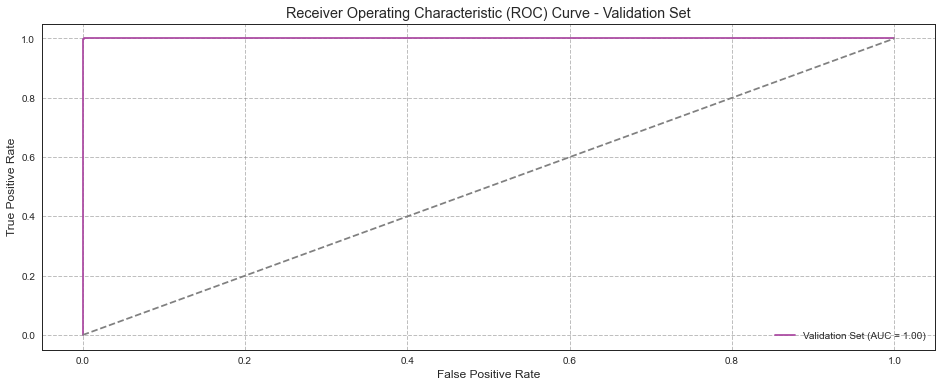

In [244]:
# Get the predicted probabilities for the positive class
y_val_proba = mlp.predict_proba(X_val)[:, 1]
y_test_proba = mlp.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds for the validation set
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_proba)

# Compute the false positive rate, true positive rate, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_proba)

# Compute the AUC score for the validation set
val_auc = auc(val_fpr, val_tpr)

# Compute the AUC score for the test set
test_auc = auc(test_fpr, test_tpr)

# Set plot style
plt.style.use('ggplot')
sns.set_style('white')

# Plot the ROC curve for the validation set
plt.figure(figsize=(16, 6))
plt.plot(val_fpr, val_tpr, label='Validation Set (AUC = {:.2f})'.format(val_auc), color='#AB49A2')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend()
plt.show()


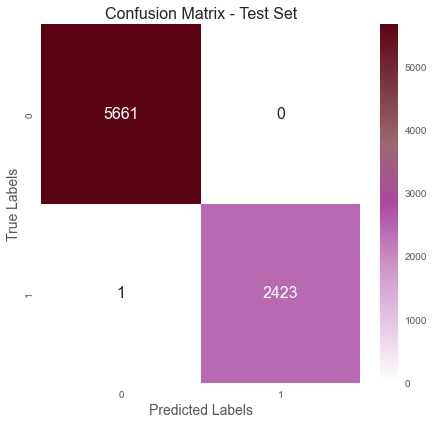

In [259]:
# Compute confusion matrix for validation set
val_cm = confusion_matrix(y_val, y_val_pred)

# Set aesthetic style
plt.style.use('ggplot')
sns.set_style('white')

plt.figure(figsize=(12,6))

# Plot confusion matrix for test set
plt.subplot(1, 2, 2)
sns.heatmap(val_cm, annot=True, fmt='d', cmap=cmap, annot_kws={"fontsize": 16})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix - Test Set', fontsize=16)

plt.tight_layout()
plt.show()

<font color='grey'> __Notes:__
    
<font color='grey'> __Evaluation Metrics:__

<font color='grey'> __1__ - __F1-Score:__ F1-Score is the harmonic mean of precision and recall. It is particularly useful when you want to balance both precision and recall in your predictions. In customer segmentation, F1-Score helps evaluate the model's ability to accurately identify customers in specific segments, considering both the accuracy of positive predictions (precision) and the coverage of actual positive instances (recall). <p>
    
<font color='grey'> __2__ - __Accuracy:__ Accuracy is the ratio of correctly predicted instances to the total number of instances. It provides a general measure of the model's overall correctness in predicting customer segments. However, accuracy alone may not be sufficient if the classes are imbalanced or if certain segments are more important than others.<p>
    
<font color='grey'> __3__ - __Precision:__ Precision is the ratio of true positives to the sum of true positives and false positives. It measures the model's ability to correctly identify customers within a specific segment. High precision is important when minimizing false positives is crucial for business decisions.<p>
    
<font color='grey'> __4__ - __Recall:__ Recall is the ratio of true positives to the sum of true positives and false negatives. It measures the model's ability to capture all relevant customers within a specific segment. High recall is important when it is crucial to identify as many positive instances as possible, reducing false negatives.<p> 
    
<font color='grey'> __ROC Curve:__

<font color='grey'> __1__ - __What it is:__ The ROC curve is created by plotting the True Positive Rate (Sensitivity) on the y-axis against the False Positive Rate (1 - Specificity) on the x-axis, at various threshold settings. Each point on the ROC curve represents a different trade-off between the true positive rate and the false positive rate. <p>
    
<font color='grey'> __2__ - __In this case:__ In the context of the hotel industry business problem described, the ROC curve could be used to evaluate the performance of predictive models in identifying canceled bookings accurately. By analyzing the ROC curve and the associated AUC-ROC values, the hotel chain can assess the effectiveness of different models in reducing cancellation rates and achieving their desired goals. The ROC curve can provide insights into the model's ability to balance revenue and risk by considering different threshold settings for classifying bookings as canceled or not.<p>

<font color='grey'> __Confusion Matrix:__

<font color='grey'> __1__ - __What it is:__ The confusion matrix summarizes the predictions made by the model in relation to the actual labels in a tabular form. For this problem, where 0 represents "not canceled" and 1 represents "canceled," the confusion matrix will have the following structure: <p>
    
<font color='grey'> __2__ - __In this case:__ Considering the business problem of reducing cancellation rates while maximizing revenue, a good confusion matrix would ideally have a high number of true positives (correctly predicted cancellations) and true negatives (correctly predicted non-cancellations) and a low number of false positives (incorrectly predicted cancellations) and false negatives (missed cancellations). However, the specific requirements and trade-offs of the business should be considered.<p>

## <font color='SeaGreen'> 5. Deployment</font>

<font color='SeaGreen'> __Select and apply appropriate modeling techniques to the data, and evaluate the performance of the models to determine the best one.__

<font color='grey'> __Deployment:__

<font color='grey'> __1__ - __Integration:__ Integrating the model into the existing systems and processes of the C hotel chain. <p>
    
<font color='grey'> __2__ - __Collaboration:__ Collaborate with the IT team or relevant stakeholders to ensure a smooth deployment process. They can assist in integrating the model into the hotel chain's booking system or any other relevant systems.<p>
    
<font color='grey'> __3__ - __Challanges:__ Consider the scalability and reliability of the deployed model to handle the volume of incoming reservations and provide real-time predictions.<p>
    
<font color='grey'> __4__ - __Monitorization:__ Monitor the performance of the deployed model over time and implement mechanisms to regularly update and retrain the model as new data becomes available.<p> 

<font color='grey'> __Business Process Change:__ Implementing predictive models for forecasting and managing cancellations requires adjustments to the existing business processes. Here are some key steps to consider:

<font color='grey'> __1__ - __Review Cancellation Policies:__ Evaluate and refine the current cancellation policies based on the insights and predictions provided by the model. This could involve updating the cancellation deadlines, penalties, and refund policies to strike a balance between reducing cancellations and maximizing revenue. <p>
    
<font color='grey'> __2__ - __Optimize Overbooking Strategy:__ Utilize the predictions from the model to optimize the overbooking strategy. This involves determining the optimal number of rooms to overbook based on the predicted cancellation rates and historical data. Adjustments may be necessary to minimize the costs and risks associated with overbooking while maximizing revenue.<p>
    
<font color='grey'> __3__ - __Integrate Predictive Insights:__ Integrate the model predictions into the revenue management system or decision-making processes. This ensures that revenue managers have access to accurate and up-to-date predictions to make informed pricing and inventory management decisions.<p>
    
<font color='grey'> __4__ - __Employee Training:__ Conduct training sessions with relevant staff, including revenue managers and front desk personnel, to familiarize them with the new processes and provide guidance on utilizing the model's predictions effectively.<p> 
    
<font color='grey'> __5__ - __Continuous Improvement:__ Monitor the performance of the implemented changes, track key metrics such as cancellation rates, revenue, and customer satisfaction, and make adjustments as necessary to continuously improve the business processes.<p> 

## <font color='SeaGreen'>Annex</font>

<font color='SeaGreen'> __For more information about other models.__

In [279]:
# Train the Random Forest model
random_forest = RandomForestClassifier(max_depth=None, max_features=None, min_samples_leaf=1,
                                       min_samples_split=2, n_estimators=100)
random_forest.fit(X_train, y_train)

# Calculate feature importance
feature_importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': random_forest.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the feature importance table
print('Random Forest - Feature Importance:')
print(feature_importance_rf)

Random Forest - Feature Importance:
                         Feature  Importance
0          ArrivalDateWeekNumber    0.302421
1         ReservationStatusMonth    0.155903
2           ReservationStatusDay    0.130020
3          ArrivalDateDayOfMonth    0.092493
4                       LeadTime    0.079862
5        MarketSegment_Online TA    0.038732
6                            ADR    0.036653
7    DepositType_Non Refund         0.025234
8              StaysInWeekNights    0.020912
9         Region_Southern Europe    0.020509
10         PreviousCancellations    0.017045
11         Region_Western Europe    0.012433
12         ReservationStatusYear    0.011761
13               ArrivalDateYear    0.010699
14        CustomerType_Transient    0.010461
15          StaysInWeekendNights    0.008500
16   DepositType_No Deposit         0.008497
17                        Adults    0.005643
18     DistributionChannel_TA/TO    0.005479
19                       Meal_SC    0.002704
20  CustomerType_Tr

In [280]:
# Train the Decision Tree model
decision_tree = DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5)
decision_tree.fit(X_train, y_train)

# Calculate feature importance
feature_importance_dt = pd.DataFrame({'Feature': feature_names, 'Importance': decision_tree.feature_importances_})
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the feature importance table
print('Decision Tree - Feature Importance:')
print(feature_importance_dt)

Decision Tree - Feature Importance:
                         Feature  Importance
0          ArrivalDateWeekNumber    0.329908
1         ReservationStatusMonth    0.154314
2           ReservationStatusDay    0.130228
3          ArrivalDateDayOfMonth    0.099654
4                       LeadTime    0.070180
5        MarketSegment_Online TA    0.044659
6    DepositType_Non Refund         0.030219
7                            ADR    0.024924
8              StaysInWeekNights    0.019985
9         Region_Southern Europe    0.019580
10         PreviousCancellations    0.017914
11         Region_Western Europe    0.010475
12        CustomerType_Transient    0.010027
13               ArrivalDateYear    0.009970
14         ReservationStatusYear    0.009354
15     DistributionChannel_TA/TO    0.006007
16          StaysInWeekendNights    0.005313
17                        Adults    0.003600
18  CustomerType_Transient-Party    0.001494
19                       Meal_SC    0.000872
20             Days

In [284]:
# Train the XGBoost model
xgboost = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7,
                            n_estimators=200, subsample=1.0)
xgboost.fit(X_train, y_train)

# Calculate feature importance
feature_importance_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': xgboost.feature_importances_})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the feature importance table
print('XGBoost - Feature Importance:')
print(feature_importance_xgb)

XGBoost - Feature Importance:
                         Feature  Importance
0    DepositType_No Deposit         0.159868
1    DepositType_Non Refund         0.159030
2        MarketSegment_Online TA    0.121074
3          Region_Western Europe    0.074895
4          PreviousCancellations    0.058837
5          ArrivalDateWeekNumber    0.052058
6    MarketSegment_Offline TA/TO    0.043122
7         Region_Southern Europe    0.042122
8         CustomerType_Transient    0.042060
9          ArrivalDateDayOfMonth    0.041781
10        ReservationStatusMonth    0.036452
11         ReservationStatusYear    0.031435
12          ReservationStatusDay    0.028728
13               ArrivalDateYear    0.021686
14  CustomerType_Transient-Party    0.018465
15                      LeadTime    0.018191
16     DistributionChannel_TA/TO    0.016966
17             StaysInWeekNights    0.012181
18                       Meal_SC    0.007045
19                           ADR    0.005706
20          StaysInWeeken

In [288]:
# Train the Bagging model
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5),
                            max_features=0.8, max_samples=1.0, n_estimators=100)
bagging.fit(X_train, y_train)

# Get the feature importances from the base estimator
base_estimator = bagging.base_estimator_
base_estimator.fit(X_train, y_train)  # Fit the base estimator
feature_importance_bagging = pd.DataFrame({'Feature': feature_names, 'Importance': base_estimator.feature_importances_})
feature_importance_bagging = feature_importance_bagging.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the feature importance table
print('Bagging - Feature Importance:')
print(feature_importance_bagging)

Bagging - Feature Importance:
                         Feature  Importance
0          ArrivalDateWeekNumber    0.328075
1         ReservationStatusMonth    0.154851
2           ReservationStatusDay    0.129274
3          ArrivalDateDayOfMonth    0.101220
4                       LeadTime    0.069281
5        MarketSegment_Online TA    0.044629
6    DepositType_Non Refund         0.030233
7                            ADR    0.025788
8              StaysInWeekNights    0.020629
9         Region_Southern Europe    0.019410
10         PreviousCancellations    0.018152
11         ReservationStatusYear    0.012038
12         Region_Western Europe    0.010739
13        CustomerType_Transient    0.010155
14               ArrivalDateYear    0.007830
15     DistributionChannel_TA/TO    0.006154
16          StaysInWeekendNights    0.003923
17                        Adults    0.003549
18                       Meal_SC    0.001112
19  CustomerType_Transient-Party    0.001105
20   MarketSegment_Offlin

In [292]:
# Train the HistGradientBoosting model
hist_gradient_boosting = HistGradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_iter=200)
hist_gradient_boosting.fit(X_train, y_train)

# Calculate permutation importances
result = permutation_importance(hist_gradient_boosting, X_train, y_train, n_repeats=10, random_state=42)

# Get feature importances and sort them in descending order
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the feature importance table
print('HistGradientBoosting - Feature Importance:')
print(feature_importances)

HistGradientBoosting - Feature Importance:
                         Feature  Importance
0           ReservationStatusDay    0.455483
1          ArrivalDateDayOfMonth    0.451188
2         ReservationStatusMonth    0.361525
3          ArrivalDateWeekNumber    0.344337
4              StaysInWeekNights    0.005900
5                       LeadTime    0.005686
6        MarketSegment_Online TA    0.002159
7           StaysInWeekendNights    0.002039
8         Region_Southern Europe    0.001909
9                ArrivalDateYear    0.001349
10         ReservationStatusYear    0.001067
11                           ADR    0.000882
12         Region_Western Europe    0.000223
13     DistributionChannel_TA/TO    0.000201
14        CustomerType_Transient    0.000122
15   MarketSegment_Offline TA/TO    0.000084
16                        Adults    0.000060
17         PreviousCancellations    0.000057
18   DepositType_Non Refund         0.000011
19                       Meal_SC    0.000008
20  Customer